<a href="https://colab.research.google.com/github/leela4821u/Monocular-Depth-Estimation/blob/main/Copy_of_unet_Diode_depth_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monocular depth estimation

**Author:** [Sandip Paul](sandippaul@live.com)<br>
**Date created:** 2022/08/15<br>
**Last modified:** 2022/09/30<br>
**Description:** Depth estimation model using Nested DWT.

## Introduction

_Depth estimation_ estimates depth scene geometry from 2D images.
In _monocular depth estimation_ the depth is predicted from a single RGB image.Here the research is on This example will show an approach to build a depth estimation model with a convnet
and simple loss functions.


## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  %%capture
!pip install tensorflow_addons
!pip install pyyaml h5py  # Required to save models in HDF5 format
!nvidia-smi
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fdFu5NGXe4rTLYKD5wOqk9dl-eJOefXo' -O nyu_data.zip

In [ ]:
import os, sys, time, pathlib, os.path, argparse, glob
from zipfile import ZipFile
from io import BytesIO
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import normalize
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, concatenate, ReLU, LeakyReLU, BatchNormalization, Conv2D, SeparableConv2D, MaxPooling2D, Dropout, UpSampling2D, Conv2DTranspose, add, multiply, Activation, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
#import tensorflow.keras as keras

import pandas as pd
import numpy as np
import cv2
import numpy
import pywt
import csv
import PIL
import imutils

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps
from skimage.transform import resize

import random
tf.random.set_seed(123)

import keras.backend as K
# from keras.layers import Layer
import keras
from keras.models import Model
from keras import backend as K
from keras.layers import Input, Conv2D, SeparableConv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose
from keras.layers import BatchNormalization, Dropout, Flatten, Lambda, Input, Conv2D, Add
#from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D, MaxPooling2D
#from keras.layers.core import Dense, Dropout, Activation
#from keras.layers.advanced_activations import ELU, LeakyReLU
#from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
#from keras.layers.noise import GaussianDropout
keras.saving.get_custom_objects().clear()
print(tf.version.VERSION)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2.15.0


## Preparing hyperparameters

In [ ]:
RGB_H = 480
RGB_W = 640
RGB_C = 3
Dep_H = 480
Dep_W = 640
Dep_C = 1

EPOCHS =10
BATCH_SIZE = 4
# HEIGHT = 256
# WIDTH = 256
# LR = 0.001 #.0002
dropout_rate = 0.5
HEIGHT = 240
WIDTH = 320
INIT_LR = 0.0001
TRAIN_PATH = '/content/data/nyu2_train.csv'
TEST_PATH = '/content/data/nyu2_test.csv'
checkpoint_path = "/content/drive/MyDrive/NDWT/cp.ckpt"

## Downloading the dataset

Training and evaluation datasets are **DIODE: A Dense Indoor and Outdoor Depth Dataset** and **[NYU-v2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html)**. Outdoor dataset **[KITTI](http://www.cvlibs.net/datasets/kitti/)** will be tried in course of time.  We use the validation set from DIODE for generating training and evaluation subsets
for our model. The reason we use the validation set rather than the training set of the original dataset is because
the training set consists of 81GB of data, which is challenging to download compared
to the validation set which is only 2.6GB. This gives a fast check for the models. For NYU we divide training, validation amd evaluation dataset as given by authors.

##  Preparing the DIODE dataset

We only use the indoor images to train our depth estimation model.

In [ ]:
annotation_folder = "/content/drive/MyDrive/colab/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

2774625282/2774625282 [==============================] - 75s 0us/step


In [ ]:
path = "val/indoors"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    #"mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}
df = pd.DataFrame(data)

df = df.sample(frac=1, random_state=42)

## Building Diode data pipeline

1. The pipeline takes a dataframe containing the path for the RGB images,
as well as the depth and depth mask files.
2. It reads and resize the RGB images (1024,768) -->(320,240).
3. It reads the depth and depth mask files, process them to generate the depth map image and
resize it.
4. It returns the RGB images and the depth map images for a batch.

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(768, 1024), n_channels=3, shuffle=True): #768, 1024
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        # if (index + 1) * self.batch_size > len(self.indices):
        #     self.batch_size = len(self.indices) - index * self.batch_size
        # # Generate one batch of data
        # # Generate indices of the batch
        # index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # # Find list of IDs
        # batch = [self.indices[k] for k in index]
        # x, y = self.data_generation(batch)

        # return x, y
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.indices))
        batch_indices = self.indices[start_idx:end_idx]

        x, y = self.data_generation(batch_indices)

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_map):  #, mask
        """Load input and target image."""

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, (320,240))
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = np.load(depth_map).squeeze()

        #mask = np.load(mask)
        #mask = mask > 0

        max_depth = min(300, np.percentile(depth_map, 99))
        depth_map = np.clip(depth_map, self.min_depth, max_depth)
        depth_map = np.log(depth_map) #, where=mask)

        #depth_map = np.ma.masked_where(~mask, depth_map)

        depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
        depth_map = cv2.resize(depth_map, (320,240))
        depth_map = np.expand_dims(depth_map, axis=2)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["image"][batch_id],
                self.data["depth"][batch_id],
                #self.data["mask"][batch_id],
            )

        return x, y


## Visualizing samples (optional)

In [ ]:

def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")
    Sa=10
    if test:
        print("PRinting model ")
        pred = model.predict(input)
        print("PRinting model ")
        fig, ax = plt.subplots(Sa, 3, figsize=(50, 50))
        for i in range(Sa):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        print("PRinting just model ")
        fig, ax = plt.subplots(Sa, 2, figsize=(50, 50))
        for i in range(Sa):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)


# visualize_samples = next(
#     iter(DataGenerator(data=df, batch_size=15, dim=(HEIGHT, WIDTH)))
# )
# visualize_depth_map(visualize_samples)

PRinting model 
1/1 [==============================] - 7s 7s/step
PRinting model 


IndexError: index 5 is out of bounds for axis 0 with size 5

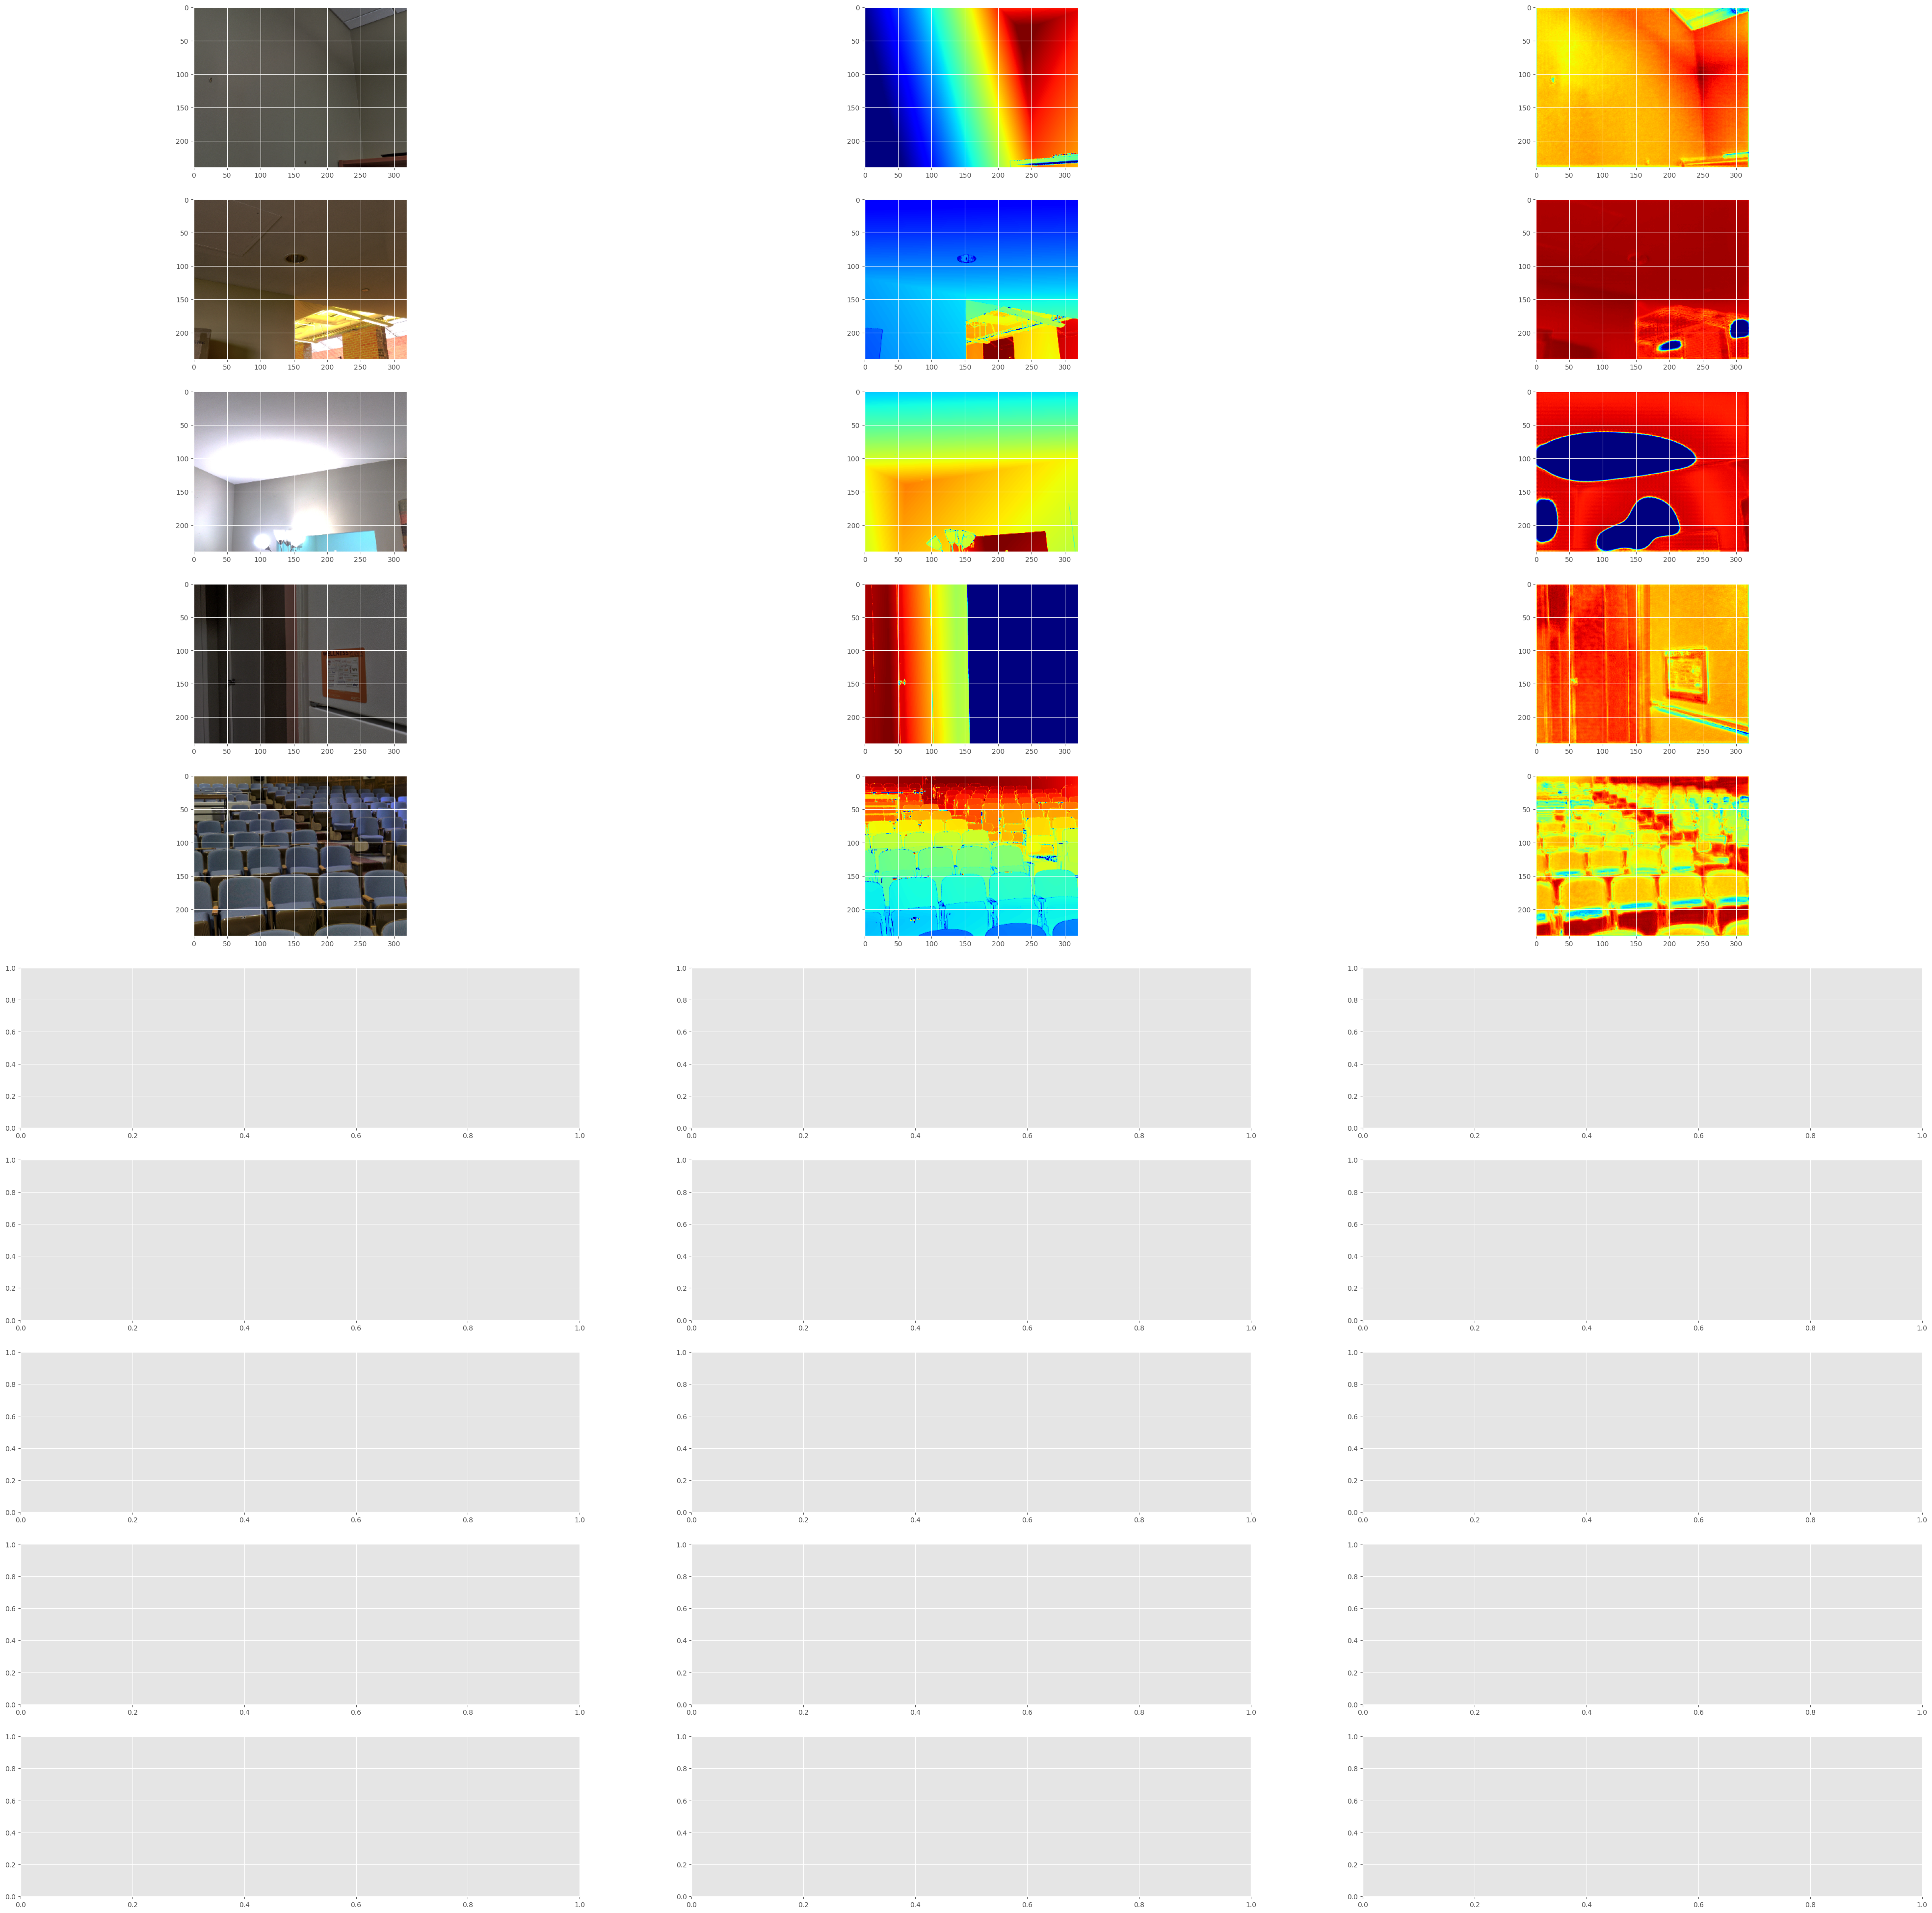

In [ ]:
test_loader = next(
    iter(
        DataGenerator(
            data=df[265:].reset_index(drop="true"), batch_size=5, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

# test_loader = next(
#     iter(
#         DataGenerator(
#             data=df[300:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
#         )
#     )
# )
# visualize_depth_map(test_loader, test=True, model=model)

## evaluation for diode dataset

In [ ]:
model = tf.keras.models.load_model(
    '/content/drive/MyDrive/colab/saved_models/keras/prunedNestNet8.keras',
    safe_mode=False  # Allow Lambda layer loading
)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/colab/saved_models/filtDWTunet10.keras')

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(true_depth, predicted_depth):
    """Calculate evaluation metrics for depth estimation."""
    true_depth_flat = true_depth.flatten()
    predicted_depth_flat = predicted_depth.flatten()

    # Mean Absolute Error
    mae = mean_absolute_error(true_depth_flat, predicted_depth_flat)

    # Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(true_depth_flat, predicted_depth_flat))

    # Threshold metrics
    threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
    threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
    threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)

    return mae, rmse, threshold_1, threshold_2, threshold_3

def evaluate_model(model, data, batch_size):
    """Evaluate a model on a dataset and return the metrics."""
    num_samples = len(data)
    num_batches = int(np.ceil(num_samples / batch_size))

    mae_list, rmse_list, thr1_list, thr2_list, thr3_list = [], [], [], [], []
    total_images = 0
    start_time = time.time()

    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        data_loader = next(iter(DataGenerator(data=batch_data, batch_size=batch_size, dim=(HEIGHT, WIDTH))))
        input, target = data_loader

        pred = model.predict(input)
        batch_size_actual = len(input)
        total_images += batch_size_actual

        for j in range(len(input)):
            mae, rmse, thr1, thr2, thr3 = calculate_metrics(target[j].squeeze(), pred[j].squeeze())
            mae_list.append(mae)
            rmse_list.append(rmse)
            thr1_list.append(thr1)
            thr2_list.append(thr2)
            thr3_list.append(thr3)
    end_time = time.time()
    evaluation_time = end_time - start_time

    mean_mae = np.mean(mae_list)
    mean_rmse = np.mean(rmse_list)
    mean_thr1 = np.mean(thr1_list)
    mean_thr2 = np.mean(thr2_list)
    mean_thr3 = np.mean(thr3_list)

    return mean_mae, mean_rmse, mean_thr1, mean_thr2, mean_thr3, total_images, evaluation_time

In [ ]:
batch_size = 12
data = df[100:300].reset_index(drop=True)

model_name = "filtDWTunet10"
mae, rmse, thr1, thr2, thr3, total_images, evaluation_time = evaluate_model(model, data, batch_size)

# Print results directly
print(f"Results for {model_name}:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Threshold < 1.25: {thr1:.4f}")
print(f"Threshold < 1.25²: {thr2:.4f}")
print(f"Threshold < 1.25³: {thr3:.4f}")
print(f"Total images evaluated: {total_images}")
print(f"Evaluation time: {evaluation_time:.2f} seconds")
print()


1/1 [==============================] - 13s 13s/step


<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
<ipython-input-8-acf979459b90>:18: RuntimeWarning: divide by zero encountered in divide
  threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)
<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / 

1/1 [==============================] - 0s 33ms/step


<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
<ipython-input-8-acf979459b90>:18: RuntimeWarning: divide by zero encountered in divide
  threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)
<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / 

1/1 [==============================] - 0s 29ms/step


<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
<ipython-input-8-acf979459b90>:18: RuntimeWarning: divide by zero encountered in divide
  threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)
<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / 

1/1 [==============================] - 0s 42ms/step


<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
<ipython-input-8-acf979459b90>:18: RuntimeWarning: divide by zero encountered in divide
  threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)
<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / 

1/1 [==============================] - 0s 29ms/step


<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
<ipython-input-8-acf979459b90>:18: RuntimeWarning: divide by zero encountered in divide
  threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)


1/1 [==============================] - 0s 52ms/step


<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
<ipython-input-8-acf979459b90>:18: RuntimeWarning: divide by zero encountered in divide
  threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)
<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / 

1/1 [==============================] - 0s 50ms/step


<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
<ipython-input-8-acf979459b90>:18: RuntimeWarning: divide by zero encountered in divide
  threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)
<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / 

1/1 [==============================] - 0s 32ms/step


<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
<ipython-input-8-acf979459b90>:18: RuntimeWarning: divide by zero encountered in divide
  threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)


1/1 [==============================] - 0s 30ms/step


<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
<ipython-input-8-acf979459b90>:18: RuntimeWarning: divide by zero encountered in divide
  threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)
<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / 

1/1 [==============================] - 0s 27ms/step


<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
<ipython-input-8-acf979459b90>:18: RuntimeWarning: divide by zero encountered in divide
  threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)
<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / 

1/1 [==============================] - 0s 32ms/step


<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
<ipython-input-8-acf979459b90>:18: RuntimeWarning: divide by zero encountered in divide
  threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)
<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / 

1/1 [==============================] - 0s 30ms/step


<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
<ipython-input-8-acf979459b90>:18: RuntimeWarning: divide by zero encountered in divide
  threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)


1/1 [==============================] - 0s 28ms/step


<ipython-input-8-acf979459b90>:16: RuntimeWarning: divide by zero encountered in divide
  threshold_1 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25)
<ipython-input-8-acf979459b90>:17: RuntimeWarning: divide by zero encountered in divide
  threshold_2 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**2)
<ipython-input-8-acf979459b90>:18: RuntimeWarning: divide by zero encountered in divide
  threshold_3 = np.mean((np.maximum(true_depth_flat / predicted_depth_flat, predicted_depth_flat / true_depth_flat)) < 1.25**3)


1/1 [==============================] - 0s 29ms/step
Results for filtDWTunet10:
MAE: 0.5890
RMSE: 0.6530
Threshold < 1.25: 0.2474
Threshold < 1.25²: 0.4371
Threshold < 1.25³: 0.5937
Total images evaluated: 204
Evaluation time: 36.28 seconds



In [ ]:
print(new_model.summary())

Model: "UNetp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 main_input (InputLayer)     [(None, 240, 320, 3)]        0         []                            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 240, 320, 3)          0         ['main_input[0][0]']          
 D)                                                                                               
                                                                                                  
 conv2d_45 (Conv2D)          (None, 240, 320, 32)         128       ['main_input[0][0]']          
                                                                                                  
 conv2d_46 (Conv2D)          (None, 240, 320, 32)         896       ['main_input[0][0]']      

#Saving some pictures for test

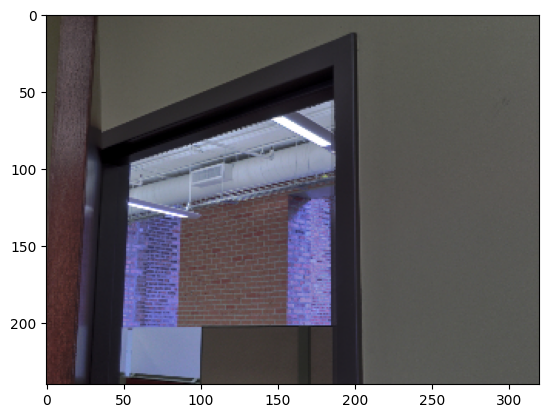

In [ ]:
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt
imx=9
for ix in range(imx):
  jx = visualize_samples[0][ix].squeeze()
  plt.imshow(jx)
  plt.imsave('/content/drive/MyDrive/colab/results/im' + str(ix) + '.png', jx)


## 3D point cloud visualization

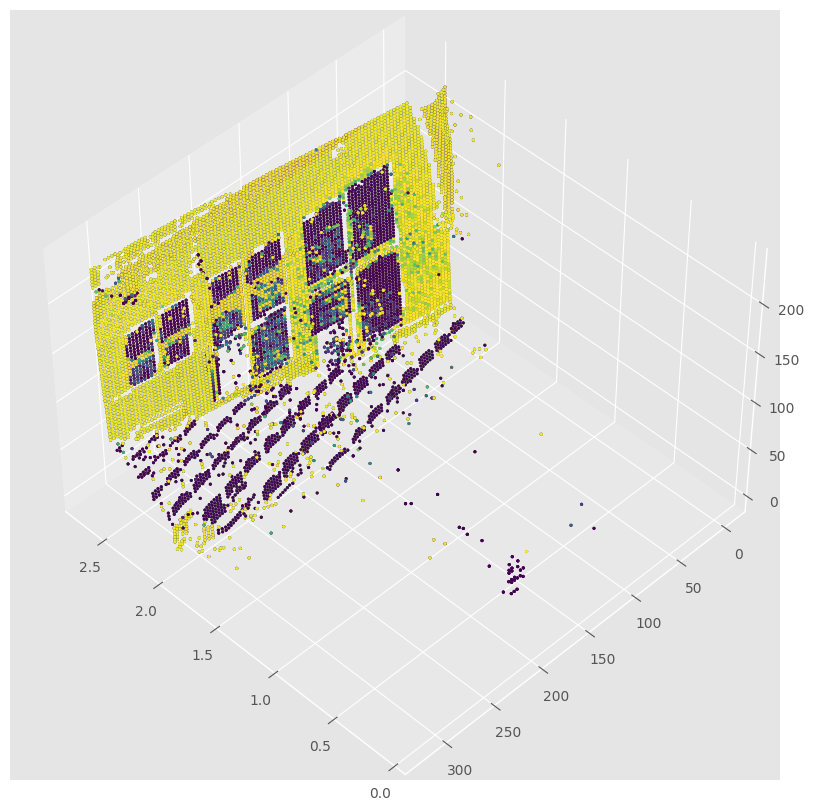

In [ ]:
depth_vis = np.flipud(visualize_samples[1][1].squeeze())  # target
img_vis = np.flipud(visualize_samples[0][1].squeeze())  # input

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection="3d")

STEP = 3
for x in range(0, img_vis.shape[0], STEP):
    for y in range(0, img_vis.shape[1], STEP):
        ax.scatter(
            [depth_vis[x, y]] * 3,
            [y] * 3,
            [x] * 3,
            c=tuple(img_vis[x, y, :3] / 255),
            s=3,
        )
    ax.view_init(45, 135)

In [ ]:
training_generator = DataGenerator(
    data=df[:260].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_generator = DataGenerator(
    data=df[260:].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)

#Load NYU Data and build data pipeline (either DIODE or this)

In [ ]:
!git clone https://gitlab.com/siddinc/new_depth.git ./data

Cloning into './data'...
remote: Enumerating objects: 65371, done.
remote: Counting objects: 100% (65371/65371), done.
remote: Compressing objects: 100% (65369/65369), done.
remote: Total 65371 (delta 2), reused 65371 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (65371/65371), 2.79 GiB | 44.84 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (65418/65418), done.


In [ ]:
# loading the dataset

def read_csv(csv_file_path):
  with open(csv_file_path, 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    return [('./' + row[0], './' + row[1]) for row in csv_reader if len(row) > 0]

def train_val_split(train_paths, val_size):
  random.shuffle(train_paths)
  len_train_paths = len(train_paths)
  i = int(len_train_paths*(1.0 - val_size))
  train = train_paths[0:i]
  val = train_paths[i:len(train_paths)]
  return train, val

def load_train_paths(train_path):
  train_paths = read_csv(train_path)
  labels = {img_path: dm_path for img_path, dm_path in train_paths}
  x_paths = [img_path for img_path, dm in train_paths]
  x_train_paths, x_val_paths = train_val_split(x_paths, 0.3)

  partition = {
    'train': x_train_paths,
    'validation': x_val_paths
  }
  return partition, labels

In [ ]:
# preprocessing the dataset

def normalize_img(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img

def preprocess_image(img_path, horizontal_flip=False):
  image = cv2.imread(img_path)
  image = imutils.resize(image, height=HEIGHT)
  # image = image[:, 21:149].astype("float")
  image = image.astype("float")
  image = normalize_img(image)

  if horizontal_flip:
    image = cv2.flip(image, 1)
  return image

def preprocess_depth_map(depth_map_path, horizontal_flip=False):
  depth_map = cv2.imread(depth_map_path)
  depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
  depth_map = imutils.resize(depth_map, height=HEIGHT)
  # depth_map = depth_map[:, 21:149].astype("float")
  depth_map = depth_map.astype("float")
  depth_map = normalize_img(depth_map)

  if horizontal_flip:
    depth_map = cv2.flip(depth_map, 1)

  depth_map = np.reshape(depth_map, (depth_map.shape[0], depth_map.shape[1], 1))
  return depth_map

In [ ]:
# data generator

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
  def __init__(self, list_IDs, labels, batch_size=16, dim=(128,128), n_channels=3, shuffle=True, pred=False):
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.shuffle = shuffle
    self.pred = pred
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    if self.pred:
      X = self.__data_generation(list_IDs_temp)
      return X
    X, y = self.__data_generation(list_IDs_temp)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, self.dim[0], self.dim[1],self.n_channels))

    if not self.pred:
      y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1))

      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
        y[i,] = preprocess_depth_map(self.labels[ID], res)
      return X, y
    else:
      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
      return X

In [ ]:
partition, labels = load_train_paths(TRAIN_PATH)
print(len(partition['train']), len(partition['validation']))
training_generator = DataGenerator(list_IDs=partition['train'], labels=labels, batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator = DataGenerator(list_IDs=partition['validation'], labels=labels, batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

22437 9617


#Utilities- standard functions

In [ ]:
@keras.saving.register_keras_serializable(package="normalize_data", name="normalize_data_format")
def normalize_data_format(value):
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format
@keras.saving.register_keras_serializable(package="dwtdb4", name="db4_dwt")
def db4_dwt(x):
    """
    channels_last
    :param x: [samples, widht, height, channels]
    :return:
    """
    arr = list()
    # for img in x:
    coeffs2 = pywt.dwt2(x[:,:,:,:], 'db4')
    LL, (LH, HL, HH) = coeffs2

    return K.concatenate([LL], axis=-1)
@keras.saving.register_keras_serializable(package="iwtdb4", name="db4_iwt")
def db4_iwt(x):
    """
    channels_last
    :param x: [samples, widht, height, channels]
    :return:
    """
    arr = numpy.array()
    for img in x:
        recon = pywt.idwt2(img, 'db4')
        np.append(arr, recon)

    return K.concatenate(arr, axis=-1)


@keras.saving.register_keras_serializable(package="dwt", name="dwt")
def dwt(x, data_format='channels_last'):

    """
    DWT (Discrete Wavelet Transform) function implementation according to
    "Multi-level Wavelet Convolutional Neural Networks"
    by Pengju Liu, Hongzhi Zhang, Wei Lian, Wangmeng Zuo
    https://arxiv.org/abs/1907.03128
    """

    if data_format == 'channels_last':
        # [all samplesL, width, height, neurons]
        x1 = x[:, 0::2, 0::2, :]  # x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :]  # x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :]  # x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :]  # x(2i, 2j)

    elif data_format == 'channels_first':
        x1 = x[:, :, 0::2, 0::2]  # x(2i−1, 2j−1)
        x2 = x[:, :, 1::2, 0::2]  # x(2i, 2j-1)
        x3 = x[:, :, 0::2, 1::2]  # x(2i−1, 2j)
        x4 = x[:, :, 1::2, 1::2]  # x(2i, 2j)

    x_LL = x1 + x2 + x3 + x4
    x_LH = -x1 - x3 + x2 + x4
    x_HL = -x1 + x3 - x2 + x4
    x_HH = x1 - x3 - x2 + x4

    if data_format == 'channels_last':
        return K.concatenate([x_LL, x_LH, x_HL, x_HH], axis=-1)
    elif data_format == 'channels_first':
        return K.concatenate([x_LL, x_LH, x_HL, x_HH], axis=1)


@keras.saving.register_keras_serializable(package="iwt", name="iwt")
def iwt(x, data_format='channels_last'):
    """
    IWT (Inverse Wavelet Transfomr) function implementation according to
    "Multi-level Wavelet Convolutional Neural Networks"
    by Pengju Liu, Hongzhi Zhang, Wei Lian, Wangmeng Zuo
    https://arxiv.org/abs/1907.03128
    """
    if data_format == 'channels_last':

        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4

        y1 = K.stack([x1, x3], axis=2)
        y2 = K.stack([x2, x4], axis=2)
        shape = K.shape(x)

        return K.reshape(K.concatenate([y1, y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))

    elif data_format == 'channels_first':

        raise RuntimeError('WIP, please use "channels_last" instead.')

        x_LL = x[:, 0:x.shape[1]//4, :, :]
        x_LH = x[:, x.shape[1]//4:x.shape[1]//4*2, :, :]
        x_HL = x[:, x.shape[1]//4*2:x.shape[1]//4*3, :, :]
        x_HH = x[:, x.shape[1]//4*3:, :, :]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4

        y1 = K.stack([x1, x3], axis=3)
        y2 = K.stack([x2, x4], axis=3)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1, y2], axis=1), K.stack([shape[0], shape[1]//4, shape[2]*2, shape[3]*2]))

@keras.saving.register_keras_serializable(package="DWT_Pooling")
class DWT_Pooling(keras.layers.Layer):
    """
    Custom Layer performing DWT pooling operation described in :

    "Multi-level Wavelet Convolutional Neural Networks"
    by Pengju Liu, Hongzhi Zhang, Wei Lian, Wangmeng Zuo
    https://arxiv.org/abs/1907.03128

    # Arguments :
        data_format (String): 'channels_first' or 'channels_last'

    # Input shape :
        If data_format='channels_last':
            4D tensor of shape: (batch_size, rows, cols, channels)
        If data_format='channels_first':
            4D tensor of shape: (batch_size, channels, rows, cols)

    # Output shape
        If data_format='channels_last':
            4D tensor of shape: (batch_size, rows/2, cols/2, channels*4)
        If data_format='channels_first':
            4D tensor of shape: (batch_size, channels*4, rows/2, cols/2)
    """

    def __init__(self, data_format=None,**kwargs):
        super(DWT_Pooling, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        #self.data_format = keras.utils.conv_utils.normalize_data_format(data_format)

    def get_config(self):  # added to save model
         return {"data_format" : self.data_format}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def build(self, input_shape):
        super(DWT_Pooling, self).build(input_shape)

    def call(self, x):
        return dwt(x, self.data_format)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            return (input_shape[0], input_shape[1]*4, input_shape[2]//2, input_shape[3]//2)
        elif self.data_format == 'channels_last':
            return (input_shape[0], input_shape[1]//2, input_shape[2]//2, input_shape[3]*4)

@keras.saving.register_keras_serializable(package="IWT_UpSampling")
class IWT_UpSampling(keras.layers.Layer):
    """
    Custom Layer performing IWT upsampling operation described in :

    "Multi-level Wavelet Convolutional Neural Networks"
    by Pengju Liu, Hongzhi Zhang, Wei Lian, Wangmeng Zuo
    https://arxiv.org/abs/1907.03128

    # Arguments :
        data_format (String): 'channels_first' or 'channels_last'

    # Input shape :
        If data_format='channels_last':
            4D tensor of shape: (batch_size, rows, cols, channels)
        If data_format='channels_first':
            4D tensor of shape: (batch_size, channels, rows, cols)

    # Output shape
        If data_format='channels_last':
            4D tensor of shape: (batch_size, rows*2, cols*2, channels/4)
        If data_format='channels_first':
            4D tensor of shape: (batch_size, channels/4, rows*2, cols*2)
    """

    def __init__(self, data_format=None, **kwargs):
        super(IWT_UpSampling, self).__init__(**kwargs)
        #self.data_format = K.normalize_data_format(data_format)
        self.data_format = normalize_data_format(data_format)

    def get_config(self):  # added to save model
         return {"data_format" : self.data_format}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def build(self, input_shape):
        super(IWT_UpSampling, self).build(input_shape)

    def call(self, x):
        return iwt(x, self.data_format)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            return ( input_shape[0], input_shape[1]//4, input_shape[2]*2, input_shape[3]*2 )
        elif self.data_format == 'channels_last':
            return ( input_shape[0], input_shape[1]*2, input_shape[2]*2, input_shape[3]//4 )

@keras.saving.register_keras_serializable(package="DWT_Pooling_Db4")
class DWT_Pooling_Db4(keras.layers.Layer):
    """
    Custom Layer performing DWT pooling operation with db4 :
    Author Sandip

    # Output shape
        If data_format='channels_last':
            4D tensor of shape: (batch_size, rows/2, cols/2, channels*4)
        If data_format='channels_first':
            4D tensor of shape: (batch_size, channels*4, rows/2, cols/2)
    """

    def __init__(self, **kwargs):
        super(DWT_Pooling_Db4, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DWT_Pooling_Db4, self).build(input_shape)

    def call(self, x):
        return db4_dwt(x)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]//2, input_shape[2]//2, input_shape[3]*4)

@keras.saving.register_keras_serializable(package="IWT_UpSampling_Db4")
class IWT_UpSampling_Db4(keras.layers.Layer):
    """
    Custom Layer performing IWT upsampling operation described in :
    """

    def __init__(self , **kwargs):
        super(IWT_UpSampling_Db4, self).__init__(**kwargs)

    def build(self, input_shape):
        super(IWT_UpSampling_Db4, self).build(input_shape)

    def call(self, x):
        return db4_iwt(x)

    def compute_output_shape(self, input_shape):
        return ( input_shape[0], input_shape[1]*2, input_shape[2]*2, input_shape[3]//4 )
#import tensorflow.keras as keras
#from keras.layers import Conv2D, SeparableConv2D
@keras.saving.register_keras_serializable(package="DepthwiseSeparableConv2D")
class DepthwiseSeparableConv2D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, kernel_initializer, padding, activation):
    super(DepthwiseSeparableConv2D, self).__init__()
    self.depthwise = DepthwiseConv2D(kernel_size = kernel_size, kernel_initializer = kernel_initializer, padding = padding, activation = activation)
    self.pointwise = Conv2D(filters = filters, kernel_size = (1, 1), activation = activation)

  def call(self, input_tensor):
    x = self.depthwise(input_tensor)
    return self.pointwise(x)


In [ ]:
# Residual
def standard_unit(input_tensor, stage, nb_filter, kernel_size=(3, 3), batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    '''x = Conv2D(filters=nb_filter, kernel_size=(3,3), padding='same')(input_tensor)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=nb_filter, kernel_size=(3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    output = Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal',padding="same")(input_tensor)
    output = LeakyReLU(alpha=0.2)(output)
    output = Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal',padding="same")(output)
    output = LeakyReLU(alpha=0.2)(output)
    output = Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal',padding="same")(output)
    x = LeakyReLU(alpha=0.2)(output)
    x = BatchNormalization()(x)'''
    # first layer
    d = layers.Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    #d = DepthwiseSeparableConv2D(filters=64, kernel_size=(3,3), padding="valid", activation="relu")(visible)
    #d = DepthwiseSeparableConv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    #d = SeparableConv2D(nb_filter, kernel_size,depthwise_initializer = 'he_normal', pointwise_initializer= 'he_normal',padding='same')(input_tensor)
    #x = layers.Activation('relu')(d)
    x = layers.BatchNormalization()(d)# axis-3
    x = layers.LeakyReLU(alpha=0.2)(x)

    # second layer
    x = layers.Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(x)
    #x = DepthwiseSeparableConv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(x)
    #x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)# axis-3
    x = layers.LeakyReLU(alpha=0.2)(x)
    #x = layers.BatchNormalization()(x)# axis-3
    # third layer
    #x = layers.Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(x)
    #x = layers.Activation('relu')(x)
    #x = layers.BatchNormalization()(x)# axis-3
    #x = layers.LeakyReLU(alpha=0.2)(x)
    #x = layers.BatchNormalization()(x)# axis-3
    # fourth layer
    x = layers.Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(x)
    #x = DepthwiseSeparableConv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(x)
    res_path = layers.add([d, x])
    #x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(res_path)# axis-3
    x = layers.LeakyReLU(alpha=0.2)(x)
    #x = layers.BatchNormalization()(x)

    #x += d
    #shortcut = layers.Conv2D(nb_filter, kernel_size=(1, 1), padding='same')(input_tensor)
    #if batchnorm:
    #   shortcut = layers.BatchNormalization()(shortcut)
    #res_path = layers.add([shortcut, x])
    #x += shortcut
    #x = layers.Activation('relu')(res_path)'''
    return x

def standard_unit1(input_tensor, stage, nb_filter, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = layers.Conv2D(filters = nb_filter, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = layers.BatchNormalization()(x)# axis-3
    x = layers.Activation('relu')(x)

    # second layer
    x = layers.Conv2D(filters = nb_filter, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def standard_unit(input_tensor, stage, nb_filter, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = layers.Conv2D(filters = nb_filter, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = layers.BatchNormalization()(x)# axis-3
    x = layers.Activation('relu')(x)

    # second layer
    x = layers.Conv2D(filters = nb_filter, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

#changing and expirementing this
# def standard_unit(input_tensor, stage, nb_filter, kernel_size = 3, batchnorm = True):
#     # 1x1 convolution
#     conv_1x1 = layers.Conv2D(filters=nb_filter, kernel_size=(1, 1),
#                              kernel_initializer='he_normal', padding='same')(input_tensor)
#     conv_1x1 = layers.BatchNormalization()(conv_1x1)
#     conv_1x1 = layers.Activation('relu')(conv_1x1)

#     # 3x3 convolution
#     conv_3x3 = layers.Conv2D(filters=nb_filter, kernel_size=(3, 3),
#                              kernel_initializer='he_normal', padding='same')(input_tensor)
#     conv_3x3 = layers.BatchNormalization()(conv_3x3)
#     conv_3x3 = layers.Activation('relu')(conv_3x3)

#     # 5x5 convolution
#     conv_5x5 = layers.Conv2D(filters=nb_filter, kernel_size=(5, 5),
#                              kernel_initializer='he_normal', padding='same')(input_tensor)
#     conv_5x5 = layers.BatchNormalization()(conv_5x5)
#     conv_5x5 = layers.Activation('relu')(conv_5x5)

#     # 3x3 max pooling followed by 1x1 convolution
#     pool_proj = layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(input_tensor)
#     pool_proj = layers.Conv2D(filters=nb_filter, kernel_size=(1, 1),
#                               kernel_initializer='he_normal', padding='same')(pool_proj)
#     pool_proj = layers.BatchNormalization()(pool_proj)
#     pool_proj = layers.Activation('relu')(pool_proj)

#     # Concatenate all filters
#     x = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
#     return x
# def standard_unit1(input_tensor, stage, nb_filter, kernel_size = 3, batchnorm = True):
#     # 1x1 convolution
#     conv_1x1 = layers.Conv2D(filters=nb_filter, kernel_size=(1, 1),
#                              kernel_initializer='he_normal', padding='same')(input_tensor)
#     conv_1x1 = layers.BatchNormalization()(conv_1x1)
#     conv_1x1 = layers.Activation('relu')(conv_1x1)

#     # 3x3 convolution
#     conv_3x3 = layers.Conv2D(filters=nb_filter, kernel_size=(3, 3),
#                              kernel_initializer='he_normal', padding='same')(input_tensor)
#     conv_3x3 = layers.BatchNormalization()(conv_3x3)
#     conv_3x3 = layers.Activation('relu')(conv_3x3)

#     # 5x5 convolution
#     conv_5x5 = layers.Conv2D(filters=nb_filter, kernel_size=(5, 5),
#                              kernel_initializer='he_normal', padding='same')(input_tensor)
#     conv_5x5 = layers.BatchNormalization()(conv_5x5)
#     conv_5x5 = layers.Activation('relu')(conv_5x5)

#     # 3x3 max pooling followed by 1x1 convolution
#     pool_proj = layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(input_tensor)
#     pool_proj = layers.Conv2D(filters=nb_filter, kernel_size=(1, 1),
#                               kernel_initializer='he_normal', padding='same')(pool_proj)
#     pool_proj = layers.BatchNormalization()(pool_proj)
#     pool_proj = layers.Activation('relu')(pool_proj)

#     # Concatenate all filters
#     x = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
#     return x



def gating_signal(input_tensor, nb_filter, batchnorm = True):
    x = layers.Conv2D(filters = nb_filter, kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = layers.BatchNormalization()(x)# axis-3
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gs, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gs)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gs)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])
    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [ ]:
def downsampling_block(input_tensor, n_filters):
  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(input_tensor)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  #shortcut = Conv2D(filters=n_filters, kernel_size=(1,1), padding='same')(input_tensor)
  #shortcut = BatchNormalization()(shortcut)
  #shortcut = LeakyReLU(alpha=0.2)(shortcut)
  #x = add([shortcut, x])
  return x

def upsampling_block(input_tensor, n_filters, name, concat_with):
  #x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)
  x = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), name=name, padding='same')(input_tensor)
  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convA")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = concatenate([x, concat_with], axis=3)

  #shortcut = Conv2D(filters=n_filters, kernel_size=(1,1), padding='same')(x)
  #shortcut = BatchNormalization()(shortcut)
  #shortcut = LeakyReLU(alpha=0.2)(shortcut)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  #x = add([shortcut, x])

  return x


## Building the model

1. The basic model is from U-Net.
2. Addditive skip-connections are implemented in the downscaling block.
3. Advanced models like DWT pooling Nested U-Net developed

In [ ]:

class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x


In [ ]:

class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 1.0 #0.85
        self.l1_loss_weight = 0.2
        self.edge_loss_weight = 0.0
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss))

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)


UNET- Version 2 ( Standard and Residual)

In [ ]:
def UNet(img_rows, img_cols, color_type=3, num_class=1): # filter_num-16, dropout = 0.1
    nb_filter = [32,64,128,256,512]
    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)
    #pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)
    #pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)
    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)
    #pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)
    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)
    #pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)

  # bottleneck
    conv5_1 = standard_unit1(pool4, stage='51', nb_filter=nb_filter[4])

    # Upsampling layers

    up41 = layers.Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up41', padding='same')(conv5_1)
    #up41 = Conv2D(filters=nb_filter[3], kernel_size=(3, 3), padding='same', name="conv41")(up41)
    #up41 = LeakyReLU(alpha=0.2)(up41)
    conv41 = layers.concatenate([up41, conv4_1], name='merge41', axis=bn_axis)
    conv41 = standard_unit1(conv41, stage='41', nb_filter=nb_filter[3])

    up31 = layers.Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up31', padding='same')(conv41)
    #up31 = Conv2D(filters=nb_filter[2], kernel_size=(3, 3), padding='same', name="conv31")(up31)
    #up31 = LeakyReLU(alpha=0.2)(up31)
    conv31 = layers.concatenate([up31, conv3_1], name='merge31', axis=bn_axis)
    conv31 = standard_unit1(conv31, stage='31', nb_filter=nb_filter[2])

    up21 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up21', padding='same')(conv31)
    #up21 = Conv2D(filters=nb_filter[1], kernel_size=(3, 3), padding='same', name="conv21")(up21)
    #up21 = LeakyReLU(alpha=0.2)(up21)
    conv21 = layers.concatenate([up21, conv2_1], name='merge21', axis=bn_axis)
    conv21 = standard_unit1(conv21, stage='21', nb_filter=nb_filter[1])

    up11 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up11', padding='same')(conv21)
    #up11 = Conv2D(filters=nb_filter[0], kernel_size=(3, 3), padding='same', name="conv11")(up11)
    #up11 = LeakyReLU(alpha=0.2)(up11)
    conv11 = layers.concatenate([up11, conv1_1], name='merge11', axis=bn_axis)
    conv11 = standard_unit1(conv11, stage='11', nb_filter=nb_filter[0])

    # 1*1 convolutional layers
    #conv_final = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid', name='UNET')(conv_final)
    #conv_final = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='UNET')(conv11)
    # Model
    model = Model(img_input, [conv_final],name="U-Net")
    return model


Attention  + Unet

In [ ]:
def AUNet(img_rows, img_cols, color_type=3, num_class=1): # filter_num-16, dropout = 0.1
    nb_filter = [32,64,128,256,512]
    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')
 # Downsampling layers
    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0]) #128
    pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1) #64

    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1]) #64, 32
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2]) #32,16
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[3])#16,8
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    conv5_1 = standard_unit1(pool4, stage='51', nb_filter=nb_filter[4]) #conv_8

    # Upsampling layers
    gs41=gating_signal(conv5_1, nb_filter[3]) #16
    a41= attention_block(conv4_1, gs41, nb_filter[3])
    up41 = layers.Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up41', padding='same')(conv5_1)
    conv41 = layers.concatenate([up41, a41], name='merge41', axis=bn_axis)
    uconv41 = standard_unit1(conv41, stage='41', nb_filter=nb_filter[3])

    gs31=gating_signal(conv4_1, nb_filter[2]) #32
    a31= attention_block(conv3_1, gs31, nb_filter[2])
    up31 = layers.Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up31', padding='same')(uconv41)
    conv31 = layers.concatenate([up31, a31], name='merge31', axis=bn_axis)
    uconv31 = standard_unit1(conv31, stage='31', nb_filter=nb_filter[2])

    gs21=gating_signal(conv3_1, nb_filter[1]) #64
    a21= attention_block(conv2_1, gs21, nb_filter[1])
    up21 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up21', padding='same')(uconv31)
    conv21 = layers.concatenate([up21, a21], name='merge21', axis=bn_axis)
    uconv21 = standard_unit1(conv21, stage='21', nb_filter=nb_filter[1])

    gs11=gating_signal(conv2_1, nb_filter[0]) #128
    a11= attention_block(conv1_1, gs11, nb_filter[0])
    up11 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up11', padding='same')(uconv21)
    conv11 = layers.concatenate([up11, a11], name='merge11', axis=bn_axis)
    uconv11 = standard_unit1(conv11, stage='11', nb_filter=nb_filter[0])

    # 1*1 convolutional layers
    #conv_final = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(uconv11)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid', name='AUNET')(conv_final)

    # Model
    model = Model(img_input, [conv_final], name="Attn-UNet")
    return model


#Discrete Wavelet (DWT)

In [ ]:
# from https://github.com/AureliePeng/Keras-WaveletTransform

def unetWavelet(height, width, depth):
    input_size=(height, width, depth)
    n_filters=64
    def down_block(input_layer, filters, kernel_size=(3, 3), activation="relu"):
        #output = Conv2D(filters, kernel_size, kernel_initializer = 'he_normal',padding="same", activation=activation)(input_layer)
        output = Conv2D(filters, kernel_size, kernel_initializer = 'he_normal',padding="same")(input_layer)
        output = LeakyReLU(alpha=0.2)(output)
        output = Conv2D(filters, kernel_size, kernel_initializer = 'he_normal',padding="same")(output)
        output = LeakyReLU(alpha=0.2)(output)
        output = Conv2D(filters, kernel_size, kernel_initializer = 'he_normal',padding="same")(output)
        output = LeakyReLU(alpha=0.2)(output)
        return output, DWT_Pooling()(output)


    def up_block(input_layer, residual_layer, filters, kernel_size=(3, 3), activation="relu"):
        output = IWT_UpSampling()(input_layer)
        output = Add()([residual_layer, output])
        output = Conv2D(filters, kernel_size, kernel_initializer = 'he_normal', padding="same")(output)
        output = LeakyReLU(alpha=0.2)(output)
        output = Conv2D(filters, kernel_size, kernel_initializer = 'he_normal', padding="same")(output)
        output = LeakyReLU(alpha=0.2)(output)
        output = Conv2D(filters * 2, kernel_size, kernel_initializer = 'he_normal', padding="same")(output)
        output = LeakyReLU(alpha=0.2)(output)
        return output

    inputs = Input(shape=input_size)

    down1, pool1 = down_block(inputs, n_filters * 1)
    down2, pool2 = down_block(pool1, n_filters * 2)
    down3, pool3 = down_block(pool2, n_filters * 4)
    down4, pool4 = down_block(pool3, n_filters * 8)

    down5 = Conv2D(filters=n_filters * 16, kernel_size=(3, 3), padding="same", activation="relu")(pool4)
    down5 = Conv2D(filters=n_filters * 16, kernel_size=(3, 3), padding="same", activation="relu")(down5)
    down5 = Conv2D(filters=n_filters * 32, kernel_size=(3, 3), padding="same", activation="relu")(down5)

    up = up_block(down5, down4, n_filters * 8)
    up = up_block(up, down3, n_filters * 4)
    up = up_block(up, down2, n_filters * 2)
    up = up_block(up, down1, n_filters * 1)

    #output = Conv2D(filters=input_size[2], kernel_size=(1, 1), padding="same")(up)
    outputs = Conv2D(1, (1, 1), padding="same")(up)
    model = Model(inputs=[inputs], outputs=[outputs],name="DWT-UNet1")
    return model

DWTUnet _ version 2 (Standard & Residual)

In [ ]:
def Udwt(img_rows, img_cols, color_type=3, num_class=1): # filter_num-16, dropout = 0.1
    nb_filter = [32,64,128,256,512]
    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = DWT_Pooling()(conv1_1)

    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = DWT_Pooling()(conv2_1)

    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = DWT_Pooling()(conv3_1)

    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = DWT_Pooling()(conv4_1)
    ##############changing to stdunit1
    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up41 = IWT_UpSampling()(conv5_1)
    up41 = layers.Conv2D(filters = nb_filter[3], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up41)
    conv41 = Add()([up41, conv4_1])
    conv41 = standard_unit1(conv41, stage='12', nb_filter=nb_filter[3])

    up31 = IWT_UpSampling()(conv41)
    up31 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up31)
    conv31 = Add()([up31, conv3_1])
    conv31 = standard_unit1(conv31, stage='12', nb_filter=nb_filter[2])

    up21 = IWT_UpSampling()(conv31)
    up21 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up21)
    conv21 = Add()([up21, conv2_1])
    conv21 = standard_unit1(conv21, stage='12', nb_filter=nb_filter[1])

    up11 = IWT_UpSampling()(conv21)
    up11 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up11)
    conv11 = Add()([up11, conv1_1])
    conv11 = standard_unit1(conv11, stage='12', nb_filter=nb_filter[0])

    # 1*1 convolutional layers
    #conv_final = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid', name='UDWT')(conv_final)

    # Model
    model = Model(img_input, [conv_final],name="DWT-UNet2")
    return model


# changing dwtunet

In [ ]:
def Udwt(img_rows, img_cols, color_type=3, num_class=1): # filter_num-16, dropout = 0.1
    nb_filter = [16,32,64,128,256,512,1024]
    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = DWT_Pooling()(conv1_1)

    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = DWT_Pooling()(conv2_1)

    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = DWT_Pooling()(conv3_1)

    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = DWT_Pooling()(conv4_1)
    ##############changing to stdunit1
    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up41 = IWT_UpSampling()(conv5_1)
    up41 = layers.Conv2D(filters = nb_filter[5], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up41)
    print(up41.shape)
    print(conv4_1.shape)
    conv41 = Add()([up41, conv4_1])
    conv41 = standard_unit1(conv41, stage='12', nb_filter=nb_filter[3])

    up31 = IWT_UpSampling()(conv41)
    up31 = layers.Conv2D(filters = nb_filter[4], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up31)
    print(up31.shape)
    print(conv3_1.shape)
    conv31 = Add()([up31, conv3_1])
    conv31 = standard_unit1(conv31, stage='12', nb_filter=nb_filter[2])

    up21 = IWT_UpSampling()(conv31)
    up21 = layers.Conv2D(filters = nb_filter[3], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up21)
    print(up21.shape)
    print(conv2_1.shape)
    conv21 = Add()([up21, conv2_1])
    conv21 = standard_unit1(conv21, stage='12', nb_filter=nb_filter[1])

    up11 = IWT_UpSampling()(conv21)
    up11 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up11)
    print(up11.shape)
    print(conv1_1.shape)
    conv11 = Add()([up11, conv1_1])
    conv11 = standard_unit1(conv11, stage='12', nb_filter=nb_filter[0])

    # 1*1 convolutional layers
    #conv_final = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid', name='UDWT')(conv_final)

    # Model
    model = Model(img_input, [conv_final],name="DWT-UNet2")
    return model


In [ ]:

model = Udwt(HEIGHT, WIDTH, color_type=3, num_class=1)

model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])


(None, 30, 40, 512)
(None, 30, 40, 512)
(None, 60, 80, 256)
(None, 60, 80, 256)
(None, 120, 160, 128)
(None, 120, 160, 128)
(None, 240, 320, 64)
(None, 240, 320, 64)


Attension + DWT

In [ ]:
def AUdwt(img_rows, img_cols, color_type=3, num_class=1): # filter_num-16, dropout = 0.1
    nb_filter = [32,64,128,256,512]
    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')
 # Downsampling layers
    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = DWT_Pooling()(conv1_1)

    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = DWT_Pooling()(conv2_1)

    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = DWT_Pooling()(conv3_1)

    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = DWT_Pooling()(conv4_1)

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    # Upsampling layers
    gs41=gating_signal(conv5_1, nb_filter[3]) #16
    a41= attention_block(conv4_1, gs41, nb_filter[3])
    up41 = IWT_UpSampling()(conv5_1)
    up41 = layers.Conv2D(filters = nb_filter[3], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up41)
    conv41 = Add()([up41, a41])
    conv41 = standard_unit1(conv41, stage='41', nb_filter=nb_filter[3])

    gs31=gating_signal(conv4_1, nb_filter[2]) #32
    a31= attention_block(conv3_1, gs31, nb_filter[2])
    up31 = IWT_UpSampling()(conv41)
    up31 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up31)
    conv31 = Add()([up31, a31])
    conv31 = standard_unit1(conv31, stage='31', nb_filter=nb_filter[2])

    gs21=gating_signal(conv3_1, nb_filter[1]) #64
    a21= attention_block(conv2_1, gs21, nb_filter[1])
    up21 = IWT_UpSampling()(conv31)
    up21 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up21)
    conv21 = Add()([up21, a21])
    conv21 = standard_unit1(conv21, stage='21', nb_filter=nb_filter[1])

    gs11=gating_signal(conv2_1, nb_filter[0]) #128
    a11= attention_block(conv1_1, gs11, nb_filter[0])
    up11 = IWT_UpSampling()(conv21)
    up11 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up11)
    conv11 = Add()([up11, a11])
    conv11 = standard_unit1(conv11, stage='11', nb_filter=nb_filter[0])

    # 1*1 convolutional layers
    #conv_final = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid', name='UNET')(conv_final)

    # Model
    model = Model(img_input, [conv_final],name="AttnDWT-UNet")
    return model


#*UNET*++ (Standard & Residual)

In [ ]:
def Nest_Net(img_rows, img_cols, color_type=3, num_class=1, deep_supervision=False):
    #added 16
    nb_filter = [16,32,64,128,256,512]

    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = layers.concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = layers.concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = layers.concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = layers.Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = layers.concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = layers.concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = layers.concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = layers.Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = layers.concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = layers.Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = layers.concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = layers.concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = layers.concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    #nestnet_output_1 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    #nestnet_output_2 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    #nestnet_output_3 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='UNETP', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    else:
        model = Model(img_input, [nestnet_output_4], name="UNetp")

    return model


## nestnet pruning

In [ ]:
!pip install tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow_model_optimization.sparsity import keras as sparsity
def Nest_Net(img_rows, img_cols, color_type=3, num_class=1, deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = layers.concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = layers.concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = layers.concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = layers.Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = layers.concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = layers.concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = layers.concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = layers.Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = layers.concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = layers.Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = layers.concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = layers.concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = layers.concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    #nestnet_output_1 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    #nestnet_output_2 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    #nestnet_output_3 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='UNETP', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    else:
        model = Model(img_input, [nestnet_output_4], name="UNetp")

    # Pruning schedule
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.50,
            final_sparsity=0.90,
            begin_step=2000,
            end_step=10000,
            frequency=100
        )
    }

    # Apply pruning to the model
    pruned_model = sparsity.prune_low_magnitude(model, **pruning_params)

    pruned_model.compile(optimizer='adam',
                         loss=tf.keras.losses.BinaryCrossentropy(),
                         metrics=['accuracy'])

    return pruned_model
callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir='./logs')
]


DWT UNET++ (Standard & Residual, Our Net)

In [ ]:
def DWTNestNet(img_rows, img_cols, color_type=1, num_class=1, deep_supervision=False):

    nb_filter = [32,64,128,256,512,1024,2048]
    bn_axis = 3
    batch_norm= True
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = DWT_Pooling()(conv1_1)

    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = DWT_Pooling()(conv2_1)

    #a11=	conv1_1, conv2_1, nb_filter[0] (x,g 32)
    #gating_11 = gating_signal(conv2_1, nb_filter[0],batch_norm)
    #a11 = attention_block(conv1_1, gating_11, nb_filter[0])
    up1_2 = IWT_UpSampling()(conv2_1)
    up1_2 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_2)
    print(up1_2.shape)
    print(conv1_1.shape)
    conv1_2 = Add()([up1_2, conv1_1])
    conv1_2 = standard_unit1(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = DWT_Pooling()(conv3_1)

    up2_2 = IWT_UpSampling()(conv3_1)
    up2_2 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_2)
    print(up2_2.shape)
    print(conv2_1.shape)
    conv2_2 = Add()([up2_2, conv2_1])
    conv2_2 = standard_unit1(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = IWT_UpSampling()(conv2_2)
    up1_3 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_3)
    print(up1_3.shape)
    print(conv1_1.shape)
    print(conv1_2.shape)
    conv1_3 = Add()([up1_3, conv1_1, conv1_2])
    conv1_3 = standard_unit1(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = DWT_Pooling()(conv4_1)

    up3_2 = IWT_UpSampling()(conv4_1)
    up3_2 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up3_2)
    print(up3_2.shape)
    print(conv3_1.shape)
    conv3_2 = Add()([up3_2, conv3_1])
    conv3_2 = standard_unit1(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = IWT_UpSampling()(conv3_2)
    up2_3 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_3)
    print(up2_3.shape)
    print(conv2_1.shape)
    print(conv2_2.shape)
    conv2_3 = Add()([up2_3, conv2_1, conv2_2])
    conv2_3 = standard_unit1(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = IWT_UpSampling()(conv2_3)
    up1_4 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_4)
    print(up1_4.shape)
    print(conv1_1.shape)
    print(conv1_2.shape)
    print(conv1_3.shape)
    conv1_4 = Add()([up1_4, conv1_1, conv1_2, conv1_3])
    conv1_4 = standard_unit1(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit1(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = IWT_UpSampling()(conv5_1)
    up4_2 = layers.Conv2D(filters = nb_filter[3], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up4_2)
    print(up4_2.shape)#(None, 30, 40, 2048)

    print(conv4_1.shape)#(None, 30, 40, 2048)
    ####################################
    conv4_2 = Add()([up4_2, conv4_1])
    conv4_2 = standard_unit1(conv4_2, stage='42', nb_filter=nb_filter[3])

    #a32= conv3_2, conv4_2, nb_filter[2] (x,g 128)
    gating_32 = gating_signal(conv4_2, nb_filter[0], batch_norm)
    a32 = attention_block(conv3_2, gating_32, nb_filter[2])
    up3_3 = IWT_UpSampling()(conv4_2)
    up3_3 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up3_3)
    print(up3_3.shape)
    print(conv3_1.shape)
    print(conv3_2.shape)
    conv3_3 = Add()([up3_3, conv3_1, conv3_2])
    conv3_3 = standard_unit1(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = IWT_UpSampling()(conv3_3)
    up2_4 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_4)
    print(up2_4.shape)
    print(conv2_1.shape)
    print(conv2_2.shape)
    print(conv2_3.shape)
    conv2_4 = Add()([up2_4, conv2_1, conv2_2, conv2_3])
    conv2_4 = standard_unit1(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = IWT_UpSampling()(conv2_4)
    up1_5 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_5)
    print(up1_5.shape)
    print(conv1_1.shape)
    print(conv1_2.shape)
    print(conv1_3.shape)
    print(conv1_4.shape)
    conv1_5 = Add()([up1_5, conv1_1, conv1_2, conv1_3, conv1_4])
    conv1_5 = standard_unit1(conv1_5, stage='15', nb_filter=nb_filter[0])

    #nestnet_output_1 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    #nestnet_output_2 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    #nestnet_output_3 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    #nestnet_output_4 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    nestnet_output_4 = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    nestnet_output_4 = layers.BatchNormalization(axis=3)(nestnet_output_4)
    nestnet_output_4 = layers.Activation('sigmoid', name='NDWT')(nestnet_output_4)
    #if deep_supervision:
    #    model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    #else:
    model = Model(img_input, [nestnet_output_4],name="DWT-UNetP")

    return model

(None, 240, 320, 256)
(None, 240, 320, 256)

(None, 120, 160, 512)
(None, 120, 160, 512)

(None, 240, 320, 256)
(None, 240, 320, 256)
(None, 240, 320, 256)

(None, 60, 80, 1024)
(None, 60, 80, 1024)

(None, 120, 160, 512)
(None, 120, 160, 512)
(None, 120, 160, 512)

(None, 240, 320, 256)
(None, 240, 320, 256)
(None, 240, 320, 256)
(None, 240, 320, 256)

(None, 30, 40, 2048)
(None, 30, 40, 2048)

(None, 60, 80, 1024)
(None, 60, 80, 1024)
(None, 60, 80, 1024)

(None, 120, 160, 512)
(None, 120, 160, 512)
(None, 120, 160, 512)
(None, 120, 160, 512)

(None, 240, 320, 256)
(None, 240, 320, 256)
(None, 240, 320, 256)
(None, 240, 320, 256)
(None, 240, 320, 256)

# EXPIREMENT

In [ ]:
def DWTNestNet(img_rows, img_cols, color_type=1, num_class=1, deep_supervision=False):
    #added 32 to nb filter
    nb_filter = [32,64,128,256,512,1024,2048]
    bn_axis = 3
    batch_norm= True
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = DWT_Pooling()(conv1_1)

    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = DWT_Pooling()(conv2_1)

    #a11=	conv1_1, conv2_1, nb_filter[0] (x,g 32)
    #gating_11 = gating_signal(conv2_1, nb_filter[0],batch_norm)
    #a11 = attention_block(conv1_1, gating_11, nb_filter[0])
    up1_2 = IWT_UpSampling()(conv2_1)
    up1_2 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_2)
    print(up1_2.shape)
    print(conv1_1.shape)
    conv1_2 = Add()([up1_2, conv1_1])
    conv1_2 = standard_unit1(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = DWT_Pooling()(conv3_1)

    up2_2 = IWT_UpSampling()(conv3_1)
    up2_2 = layers.Conv2D(filters = nb_filter[3], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_2)
    print(up2_2.shape)
    print(conv2_1.shape)
    conv2_2 = Add()([up2_2, conv2_1])
    conv2_2 = standard_unit1(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = IWT_UpSampling()(conv2_2)
    up1_3 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_3)
    print(up1_3.shape)
    print(conv1_1.shape)
    print(conv1_2.shape)
    conv1_3 = Add()([up1_3, conv1_1, conv1_2])
    conv1_3 = standard_unit1(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[2])
    pool4 = DWT_Pooling()(conv4_1)

    up3_2 = IWT_UpSampling()(conv4_1)
    up3_2 = layers.Conv2D(filters = nb_filter[4], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up3_2)
    print(up3_2.shape)
    print(conv3_1.shape)
    conv3_2 = Add()([up3_2, conv3_1])
    conv3_2 = standard_unit1(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = IWT_UpSampling()(conv3_2)
    up2_3 = layers.Conv2D(filters = nb_filter[3], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_3)
    print(up2_3.shape)
    print(conv2_1.shape)
    print(conv2_2.shape)
    conv2_3 = Add()([up2_3, conv2_1, conv2_2])
    conv2_3 = standard_unit1(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = IWT_UpSampling()(conv2_3)
    up1_4 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_4)
    print(up1_4.shape)
    print(conv1_1.shape)
    print(conv1_2.shape)
    print(conv1_3.shape)
    conv1_4 = Add()([up1_4, conv1_1, conv1_2, conv1_3])
    conv1_4 = standard_unit1(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit1(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = IWT_UpSampling()(conv5_1)
    up4_2 = layers.Conv2D(filters = nb_filter[4], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up4_2)
    print(up4_2.shape)#(None, 30, 40, 2048)

    print(conv4_1.shape)#(None, 30, 40, 2048)
    ####################################
    conv4_2 = Add()([up4_2, conv4_1])
    conv4_2 = standard_unit1(conv4_2, stage='42', nb_filter=nb_filter[3])

    #a32= conv3_2, conv4_2, nb_filter[2] (x,g 128)
    gating_32 = gating_signal(conv4_2, nb_filter[2], batch_norm)
    a32 = attention_block(conv3_2, gating_32, nb_filter[2])
    up3_3 = IWT_UpSampling()(conv4_2)
    up3_3 = layers.Conv2D(filters = nb_filter[4], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up3_3)
    print(up3_3.shape)
    print(conv3_1.shape)
    print(conv3_2.shape)
    conv3_3 = Add()([up3_3, conv3_1, conv3_2])
    conv3_3 = standard_unit1(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = IWT_UpSampling()(conv3_3)
    up2_4 = layers.Conv2D(filters = nb_filter[3], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_4)
    print(up2_4.shape)
    print(conv2_1.shape)
    print(conv2_2.shape)
    print(conv2_3.shape)
    conv2_4 = Add()([up2_4, conv2_1, conv2_2, conv2_3])
    conv2_4 = standard_unit1(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = IWT_UpSampling()(conv2_4)
    up1_5 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_5)
    print(up1_5.shape)
    print(conv1_1.shape)
    print(conv1_2.shape)
    print(conv1_3.shape)
    print(conv1_4.shape)
    conv1_5 = Add()([up1_5, conv1_1, conv1_2, conv1_3, conv1_4])
    conv1_5 = standard_unit1(conv1_5, stage='15', nb_filter=nb_filter[0])

    #nestnet_output_1 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    #nestnet_output_2 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    #nestnet_output_3 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    #nestnet_output_4 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    nestnet_output_4 = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    nestnet_output_4 = layers.BatchNormalization(axis=3)(nestnet_output_4)
    nestnet_output_4 = layers.Activation('sigmoid', name='NDWT')(nestnet_output_4)
    #if deep_supervision:
    #    model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    #else:
    model = Model(img_input, [nestnet_output_4],name="DWT-UNetP")

    return model

In [ ]:
model =  DWTNestNet(HEIGHT, WIDTH, color_type=3, num_class=1, deep_supervision=False)
#model  = ADWTNestNet(HEIGHT, WIDTH, color_type=3, num_class=1, deep_supervision=False)
#model  = RNest_Net(HEIGHT, WIDTH, color_type=3, num_class=1, deep_supervision=False)
model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])

(None, 240, 320, 32)
(None, 240, 320, 32)
(None, 120, 160, 64)
(None, 120, 160, 64)
(None, 240, 320, 32)
(None, 240, 320, 32)
(None, 240, 320, 32)
(None, 60, 80, 128)
(None, 60, 80, 128)
(None, 120, 160, 64)
(None, 120, 160, 64)
(None, 120, 160, 64)
(None, 240, 320, 32)
(None, 240, 320, 32)
(None, 240, 320, 32)
(None, 240, 320, 32)
(None, 30, 40, 256)
(None, 30, 40, 256)
(None, 60, 80, 128)
(None, 60, 80, 128)
(None, 60, 80, 128)
(None, 120, 160, 64)
(None, 120, 160, 64)
(None, 120, 160, 64)
(None, 120, 160, 64)
(None, 240, 320, 32)
(None, 240, 320, 32)
(None, 240, 320, 32)
(None, 240, 320, 32)
(None, 240, 320, 32)


DWT Atten UNET++ (Standard & Residual, Our Net)

In [ ]:
def ADWTNestNet(img_rows, img_cols, color_type=1, num_class=1, deep_supervision=False):
    #added 32 to nb filter
    nb_filter = [32,64,128,256,512,1024,2048]
    bn_axis = 3
    batch_norm= True
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = DWT_Pooling()(conv1_1)

    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = DWT_Pooling()(conv2_1)

    #a11=	conv1_1, conv2_1, nb_filter[0] (x,g 32)
    gating_11 = gating_signal(conv2_1, nb_filter[0],batch_norm)
    a11 = attention_block(conv1_1, gating_11, nb_filter[2])#0
    print(a11.shape)
    up1_2 = IWT_UpSampling()(conv2_1)
    up1_2 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_2)
    print(up1_2.shape)
    conv1_2 = Add()([up1_2, a11])
    conv1_2 = standard_unit1(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = DWT_Pooling()(conv3_1)

    #a21= conv2_1, conv3_1, nb_filter[0] (x,g 64)
    gating_21 = gating_signal(conv3_1, nb_filter[1], batch_norm)
    a21 = attention_block(conv2_1, gating_21, nb_filter[2])#2
    up2_2 = IWT_UpSampling()(conv3_1)
    up2_2 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_2)
    print(a21.shape)
    print(up2_2.shape)
    conv2_2 = Add()([up2_2, a21])
    conv2_2 = standard_unit1(conv2_2, stage='22', nb_filter=nb_filter[1])

    #a12= conv1_2, conv2_2, nb_filter[0] (x,g 32)
    gating_12 = gating_signal(conv2_2, nb_filter[0], batch_norm)
    a12 = attention_block(conv1_2, gating_12, nb_filter[0])
    up1_3 = IWT_UpSampling()(conv2_2)
    up1_3 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_3)
    print(a11.shape)
    print(a12.shape)
    print(up1_3.shape)

    conv1_3 = Add()([up1_3, a11, a12])
    conv1_3 = standard_unit1(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = DWT_Pooling()(conv4_1)

    #a31= conv3_1, conv4_1, nb_filter[2] (x,g 128)
    gating_31 = gating_signal(conv4_1, nb_filter[2], batch_norm)
    a31 = attention_block(conv3_1, gating_31, nb_filter[2])
    up3_2 = IWT_UpSampling()(conv4_1)
    up3_2 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up3_2)
    print(a31.shape)
    print(up3_2.shape)
    conv3_2 = Add()([up3_2, a31])
    conv3_2 = standard_unit1(conv3_2, stage='32', nb_filter=nb_filter[2])


    #a22= conv2_2, conv3_2, nb_filter[1] (x,g 64)
    gating_22 = gating_signal(conv3_2, nb_filter[1], batch_norm)
    a22 = attention_block(conv2_2, gating_22, nb_filter[1])
    up2_3 = IWT_UpSampling()(conv3_2)
    up2_3 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_3)
    print(a21.shape)
    print(a22.shape)
    print(up2_3.shape)
    conv2_3 = Add()([up2_3, a21, a22])
    conv2_3 = standard_unit1(conv2_3, stage='23', nb_filter=nb_filter[1])

    #a13= conv1_3, conv2_3, nb_filter[0] (x,g 32)
    gating_13 = gating_signal(conv2_3, nb_filter[0], batch_norm)
    a13 = attention_block(conv1_3, gating_13, nb_filter[0])
    up1_4 = IWT_UpSampling()(conv2_3)
    up1_4 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_4)
    print(up1_4.shape)
    print(a11.shape)
    print(a12.shape)
    print(a13.shape)
    conv1_4 = Add()([up1_4, a11,a12, a13])
    conv1_4 = standard_unit1(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit1(pool4, stage='51', nb_filter=nb_filter[4])

    #a41= conv4_1, conv5_1, nb_filter[2] (x,g 256)
    gating_41 = gating_signal(conv5_1, nb_filter[2], batch_norm)
    a41 = attention_block(conv4_1, gating_41, nb_filter[2])
    up4_2 = IWT_UpSampling()(conv5_1)
    up4_2 = layers.Conv2D(filters = nb_filter[3], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up4_2)
    print(up4_2.shape)
    print(a41.shape)
    conv4_2 = Add()([up4_2, a41])
    conv4_2 = standard_unit1(conv4_2, stage='42', nb_filter=nb_filter[3])
    #
    #
    #
    #


    #a32= conv3_2, conv4_2, nb_filter[2] (x,g 128)
    gating_32 = gating_signal(conv4_2, nb_filter[2], batch_norm)
    a32 = attention_block(conv3_2, gating_32, nb_filter[2])
    up3_3 = IWT_UpSampling()(conv4_2)
    up3_3 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up3_3)
    print(up3_3.shape)
    print(a31.shape)
    print(a32.shape)
    conv3_3 = Add()([up3_3, a31, a32])
    conv3_3 = standard_unit1(conv3_3, stage='33', nb_filter=nb_filter[2])

    #a23= conv2_3, conv3_3, nb_filter[1] (x,g 64)
    gating_23 = gating_signal(conv3_3, nb_filter[1], batch_norm)
    a23 = attention_block(conv2_3, gating_23, nb_filter[1])
    up2_4 = IWT_UpSampling()(conv3_3)
    up2_4 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_4)
    print(up2_4.shape)
    print(a21.shape)
    print(a22.shape)
    print(a23.shape)
    conv2_4 = Add()([up2_4, a21, a22, a23])
    conv2_4 = standard_unit1(conv2_4, stage='24', nb_filter=nb_filter[1])

    #a14= conv1_4, conv2_4, nb_filter[0] (x,g 32)
    gating_14 = gating_signal(conv2_4, nb_filter[0], batch_norm)
    a14 = attention_block(conv1_4, gating_14, nb_filter[0])
    up1_5 = IWT_UpSampling()(conv2_4)
    up1_5 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_5)
    print(up1_5.shape)
    print(a11.shape)
    print(a12.shape)
    print(a13.shape)
    print(a14.shape)
    conv1_5 = Add()([up1_5, a11, a12, a13, a14])
    conv1_5 = standard_unit1(conv1_5, stage='15', nb_filter=nb_filter[0])

    #nestnet_output_1 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    #nestnet_output_2 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    #nestnet_output_3 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    #nestnet_output_4 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    nestnet_output_4 = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    nestnet_output_4 = layers.BatchNormalization(axis=3)(nestnet_output_4)
    nestnet_output_4 = layers.Activation('sigmoid', name='NDWT')(nestnet_output_4)
    #if deep_supervision:
    #    model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    #else:
    model = Model(img_input, [nestnet_output_4],name="AttnDWT-UNetP")

    return model

(None, 240, 320, 256)
(None, 240, 320, 256)

(None, 120, 160, 512)
(None, 120, 160, 512)

(None, 240, 320, 256)
(None, 240, 320, 256)
(None, 240, 320, 256)

(None, 60, 80, 1024)
(None, 60, 80, 1024)

(None, 120, 160, 512)
(None, 120, 160, 512)
(None, 120, 160, 512)

(None, 240, 320, 256)
(None, 240, 320, 256)
(None, 240, 320, 256)
(None, 240, 320, 256)

(None, 30, 40, 2048)
(None, 30, 40, 2048)

(None, 60, 80, 1024)
(None, 60, 80, 1024)
(None, 60, 80, 1024)

(None, 120, 160, 512)
(None, 120, 160, 512)
(None, 120, 160, 512)
(None, 120, 160, 512)

(None, 240, 320, 256)
(None, 240, 320, 256)
(None, 240, 320, 256)
(None, 240, 320, 256)
(None, 240, 320, 256)

## Defining the loss

We will optimize 3 losses in our mode.
1. Structural similarity index(SSIM).
2. L1-loss, or Point-wise depth in our case.
3. Depth smoothness loss.

Out of the three loss functions, SSIM contributes the most to improving model performance.

In [ ]:
@keras.saving.register_keras_serializable(package="poly_decay")
def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0
  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

opt = Adam(learning_rate=INIT_LR, amsgrad=True)

checkpoint_path = "//content/drive/MyDrive/NDWTw3/cp.ckpt"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
callbacks = [LearningRateScheduler(poly_decay),checkpoint]

# custom loss

@keras.saving.register_keras_serializable(package="depth_loss")
def depth_loss(y_true, y_pred):
  w1, w2, w3 = 1.0, 1.0, 0.2

  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
  '''abs_error = tf.abs(tf.subtract(y_pred,y_true)) # log
  c = 0.2 * tf.reduce_max(abs_error)
  berHu_loss1 = tf.where(abs_error <= c,
                  abs_error,
                  (tf.square(abs_error) + tf.square(c))/(2*c))
  l_depth = K.mean(berHu_loss1)'''

  #dy_true, dx_true = tf.image.image_gradients(y_true)
  #dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  #l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  return (w1 * l_ssim) + (w3 * K.mean(l_depth))#(w2 * K.mean(l_edges)) +

#custom soft accuracy
@keras.saving.register_keras_serializable(package="depth_acc")
def depth_acc(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


Another version

In [ ]:
ssim_loss_weight = 0.85
l1_loss_weight = 0.1
edge_loss_weight = 0.9

def train_loss(y_true, y_pred):
  theta=0.1
  maxDepthVal=1000.0/10.0
  LapFilter = K.constant([[[[0]], [[-1 ]], [[0 ]]], [[[-1]], [[5 ]], [[-1 ]]], [[[0 ]], [[-1 ]], [[0 ]]]])
  #Cosine distance loss
  #l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
  abs_error = tf.abs(tf.subtract(y_pred,y_true)) # log
  c = 0.2 * tf.reduce_max(abs_error)
  berHu_loss1 = tf.where(abs_error <= c,
                  abs_error,
                  (tf.square(abs_error) + tf.square(c))/(2*c))
  l_depth = K.mean(berHu_loss1)
  # edge loss for sharp edges
  #dy_true, dx_true = tf.image.image_gradients(y_true)
  #dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  #l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
  s_true  = tf.image.sobel_edges(y_true)
  s_pred  = tf.image.sobel_edges(y_pred)
  l_edges = K.mean(K.mean(K.abs((s_pred[...,0]/4+0.5) - (s_true[...,0]/4+0.5)) + K.abs((s_pred[...,1]/4+0.5) - (s_true[...,1]/4+0.5)), axis=-1))
  # structural similarity loss
  inputChannels = K.reshape(K.ones_like(y_true[0,0,0,:]),(1,1,-1,1))
  filt = LapFilter * inputChannels
  LapTrue = K.depthwise_conv2d(y_true,filt, padding='same' )
  LapTrue =tf.clip_by_value(LapTrue, clip_value_min=0.0, clip_value_max=1.0)
  l_ssim = K.clip((1 - tf.image.ssim(LapTrue, y_pred, maxDepthVal)) * 0.5, 0, 1)
  #l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 1, 0, 1)

  # weightage
  w1, w2, w3 = 1.0, 1.0, 0.1
  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

#optimizer
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6,amsgrad=True)
opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)
# accuracy function
def accuracy_function(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# save model frequently for later use.
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
# Learning rate scheduler
def polynomial_decay(epoch):
  max_epochs = EPOCHS
  #base_lr =  INIT_LR
  power = 1.0
  lr = INIT_LR * (1 - (epoch / float(max_epochs))) ** power
  return lr

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint]

## Possible improvements

1. You can improve this model by replacing the encoding part of the U-Net with a
pretrained DenseNet or ResNet.
2. Loss functions play an important role in solving this problem.
Tuning the loss functions may yield significant improvement.

## Model training

In [ ]:
# start = time.time()
#model = UnetModel()
#model = UNet(HEIGHT, WIDTH, color_type=3, num_class=1)
#model = AUNet(256, 256, color_type=3, num_class=1)
#model = unetWavelet()
#model = unetWavelet(HEIGHT, WIDTH, 3)
#model = Udwt(HEIGHT, WIDTH, color_type=3, num_class=1)
#model = AUdwt(256, 256, color_type=3, num_class=1)
#model = Nest_Net(HEIGHT, WIDTH, color_type=3, num_class=1)
#model = RNest_Net(256, 256, color_type=3, num_class=1)
#model = ARNest_Net(256, 256, color_type=3, num_class=1)
#odel =  DWTNestNet(HEIGHT, WIDTH, color_type=3, num_class=1, deep_supervision=False)
model  = ADWTNestNet(HEIGHT, WIDTH, color_type=3, num_class=1, deep_supervision=False)
#model  = RNest_Net(HEIGHT, WIDTH, color_type=3, num_class=1, deep_supervision=False)
model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])
# model.summary()
# end = time.time()
# print('\nTest time', end-start, 's')

(None, 240, 320, 32)
(None, 240, 320, 128)


ValueError: Inputs have incompatible shapes. Received shapes (240, 320, 128) and (240, 320, 32)

In [ ]:
r = model.fit(training_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=callbacks)
#!mkdir -p saved_model
model.save('/content/drive/MyDrive/colab/saved_models/keras/dwtnestnetstand14.keras')
model.save('/content/drive/MyDrive/colab/saved_models/h5/dwtnestnetstand14.h5')

Epoch 1/10
 2/65 [..............................] - ETA: 20s - loss: 0.3958 - depth_acc: 0.5441

KeyboardInterrupt: 

In [ ]:
model.save('/content/drive/MyDrive/colab/saved_models/DWTNestNet6.keras')
model.save('/content/drive/MyDrive/colab/saved_models/DWTNestNetu6.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/asd.h5')

ValueError: Unable to create dataset (name already exists)

In [ ]:
model.save('/content/drive/MyDrive/colab/unet_model.keras')

NameError: name 'model' is not defined

In [ ]:
model.save('/content/drive/MyDrive/audwt_model.keras')

In [ ]:
new_model = tf.keras.models.load_model('/content/modelsave/UNet.keras')

OSError: No file or directory found at /content/modelsave/UNet.keras

In [ ]:
new_model = tf.keras.models.load_model('/content/modelsave/UNet.keras')

OSError: No file or directory found at /content/modelsave/UNet.keras

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/colab/saved_models/keras/AUNet5.keras', safe_mode=False)

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/colab/saved_models/DWTunet9.keras')

In [ ]:
 new_model.summary()

Model: "DWT-UNet2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 main_input (InputLayer)     [(None, 240, 320, 3)]        0         []                            
                                                                                                  
 max_pooling2d_39 (MaxPooli  (None, 240, 320, 3)          0         ['main_input[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 conv2d_171 (Conv2D)         (None, 240, 320, 32)         128       ['main_input[0][0]']          
                                                                                                  
 conv2d_172 (Conv2D)         (None, 240, 320, 32)         896       ['main_input[0][0]']  

In [ ]:
model.summary()

Model: "DWT-UNetP"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 main_input (InputLayer)     [(None, 240, 320, 3)]        0         []                            
                                                                                                  
 conv2d_339 (Conv2D)         (None, 240, 320, 32)         896       ['main_input[0][0]']          
                                                                                                  
 batch_normalization_327 (B  (None, 240, 320, 32)         128       ['conv2d_339[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 240, 320, 32)         0         ['batch_normalization_

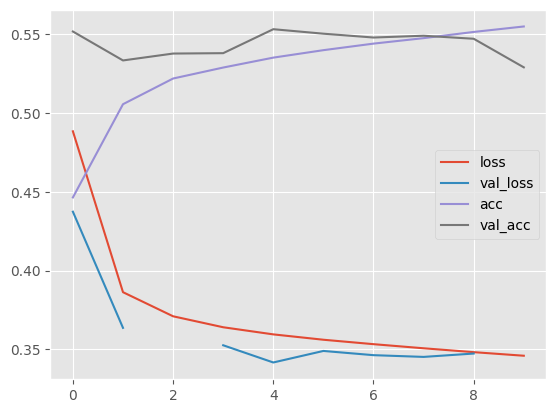

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# e = np.linspace(1, EPOCHS, num=EPOCHS)

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

plt.plot(r.history['depth_acc'], label='acc')
plt.plot(r.history['val_depth_acc'], label='val_acc')

plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/unet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/drive/MyDrive/udwt_model.keras')

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/dwtunet.h5')

FileNotFoundError: Cannot find file: /content/drive/MyDrive/dwtunet.h5

In [ ]:
custom_objects = {
    'poly_decay': poly_decay,
    'depth_loss': depth_loss,
    'depth_acc': depth_acc,
    'Custom>Adam': opt
}
with keras.saving.custom_object_scope(custom_objects):
    #new_model = load_model('/content/drive/MyDrive/Sandip Sirs Drive/unet.h5')
    new_model = load_model('/content/drive/MyDrive/colab/saved_models/UNet2ince.keras')
new_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 main_input (InputLayer)     [(None, 240, 320, 3)]        0         []                            
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 240, 320, 3)          0         ['main_input[0][0]']          
 g2D)                                                                                             
                                                                                                  
 conv2d_37 (Conv2D)          (None, 240, 320, 32)         128       ['main_input[0][0]']          
                                                                                                  
 conv2d_38 (Conv2D)          (None, 240, 320, 32)         896       ['main_input[0][0]']      

In [ ]:
from tensorflow.keras.layers import Layer, InputSpec
#from keras_utils import conv_utils
import tensorflow as tf
import keras.backend as K
import keras
from keras.models import Model
from keras.models import load_model
from keras import backend as K
from keras.layers import Input, Conv2D, SeparableConv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose
from keras.layers import BatchNormalization, Dropout, Flatten, Lambda, Input, Conv2D, Add
from keras.regularizers import l2
from keras.src.utils.np_utils import to_categorical
keras.saving.get_custom_objects().clear()
def normalize_data_format(value):
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format


def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(BilinearUpSampling2D, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        #self.data_format = conv_utils.normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        #self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)
def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0],
                    input_shape[1],
                    height,
                    width)
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0],
                    height,
                    width,
                    input_shape[3])

def call(self, inputs):
        input_shape = K.shape(inputs)
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None

        return tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR)

def get_config(self):
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0/10.0):

    # Point-wise depth
    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # Structural similarity (SSIM) index
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

#custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}
with keras.saving.custom_object_scope(custom_objects):
    #new_model = load_model('/content/drive/MyDrive/Sandip Sirs Drive/unet.h5')
    new_model = load_model('/content/drive/MyDrive/nyu.h5')
new_model.summary()

NameError: name 'BilinearUpSampling2D' is not defined

In [ ]:
tf.saved_model.load('/content/drive/MyDrive/nyu2.pb')

OSError: SavedModel file does not exist at: /content/drive/MyDrive/nyu2.pb/{saved_model.pbtxt|saved_model.pb}

FLOPs

In [ ]:
pip install keras-flops

In [ ]:
pip install model_profiler

In [ ]:
!pip install tensorflow==2.3.0
!pip install q keras==2.4.3
!pip install keras_preprocessing
!pip install keras.applications

In [ ]:
!pip install keras-utils

  Preparing metadata (setup.py) ... done
  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=9897a5e75003f67e15516dce27633b01f6a9f46b1a3936e9f750a80ae2f06f82
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras-utils


In [ ]:
pip install enum34

In [ ]:
pip install h5py

In [ ]:
!pip install keras

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/colab/saved_models/UNeT3stand.keras')

In [ ]:
new_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 main_input (InputLayer)     [(None, 240, 320, 3)]        0         []                            
                                                                                                  
 conv2d_74 (Conv2D)          (None, 240, 320, 32)         896       ['main_input[0][0]']          
                                                                                                  
 batch_normalization_74 (Ba  (None, 240, 320, 32)         128       ['conv2d_74[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_72 (Activation)  (None, 240, 320, 32)         0         ['batch_normalization_74[0

#FLOPs & MAC

In [ ]:
import tensorflow as tf
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(model.call, input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])
  graph_info = profile(forward_pass.get_concrete_function().graph, options=ProfileOptionBuilder.float_operation())
  flops = graph_info.total_float_ops
  return flops

#model = tf.keras.applications.ConvNeXtTiny()

# model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])

#flops = get_flops(new_model)
flops = get_flops(model)
macs = flops / 2
print(f"MACs: {macs / 1e+9:,} G")
print(f"FLOPs: {flops / 1e+9:,} G")


MACs: 23.88660481 G
FLOPs: 47.77320962 G


## Evaluation

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/colab/saved_models/keras/NestNet4ince.keras')

In [ ]:
img_dm_pairs = read_csv('/content/data/nyu2_test.csv')
labels = {i: j for i,j in img_dm_pairs}
test_paths = [i for i,j in img_dm_pairs]
print(len(test_paths))
partition = {'test': test_paths}

x_test = np.empty((len(test_paths), HEIGHT, WIDTH, 3))
y_test = np.empty((len(test_paths), HEIGHT, WIDTH, 1))

for i, ID in enumerate(partition['test'][:]):
  x_test[i, ] = preprocess_image(ID, horizontal_flip=False)
  y_test[i, ] = preprocess_depth_map(labels[ID], horizontal_flip=False)
print(model.evaluate(x_test, y_test))

654


ResourceExhaustedError: Graph execution error:

Detected at node UNetp/max_pooling2d_9/MaxPool defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-24-8408668a3553>", line 13, in <cell line: 13>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/pooling/base_pooling2d.py", line 84, in call

OOM when allocating tensor with shape[32,416,240,320] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node UNetp/max_pooling2d_9/MaxPool}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_13108]

In [ ]:
from matplotlib.patches import BoxStyle
def compute_errors(gt, pred):
    eps = 1e-9 #to keep values below 1
    thresh = np.maximum((gt / (pred+eps)), (pred / (gt+eps)))
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    abs_rel = np.mean(np.abs(gt - pred) / (gt+eps))
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    log_10 = (np.abs(np.log10(gt+eps)-np.log10(pred+eps))).mean()
    return a1, a2, a3, abs_rel, rmse, log_10

def DepthNorm(x, maxDepth):
    return maxDepth / x

def scale_up(scale, images):
    from skimage.transform import resize
    scaled = []

    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append( resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True ) )
        print(output_shape.shape)
    return np.stack(scaled)

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=1000), minDepth, maxDepth) / maxDepth

def evaluate(model, rgb, depth, crop, batch_size=6, verbose=False):
    N = len(rgb)
    bs = batch_size
    predictions = []
    testSetDepths = []


 #Compute results
    for i in range(N//bs):
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        x = tf.image.resize(x, [240, 320])
        # Compute results
        true_y = depth[(i)*bs:(i+1)*bs,:,:]
        true_y = np.expand_dims(true_y, -1)
        true_y = tf.image.resize(true_y, [240,320])
        ##pred_y = scale_up(1, predict(model, x/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0
        pred_y = (model.predict(x/255, batch_size=bs)) #*10
        pred_y = np.clip(DepthNorm(pred_y, maxDepth=1000), 10, 1000) / 1000

        # Test time augmentation: mirror image estimate
        ##pred_y_flip = scale_up(1, predict(model, x[...,::-1,:]/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0
        pred_y_flip = (model.predict(x[...,::-1,:]/255, batch_size=bs)) #*10
        pred_y_flip = np.clip(DepthNorm(pred_y_flip, maxDepth=1000), 10, 1000) / 1000

        # Crop based on Eigen et al. crop
        true_y = true_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y = pred_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y_flip = pred_y_flip[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]

        # Compute errors per image in batch
        for j in range(len(true_y)):
            predictions.append((0.5 * pred_y[j]) + (0.5 * np.fliplr(pred_y_flip[j]))   )
            testSetDepths.append(true_y[j])

    predictions = np.stack(predictions, axis=0)
    testSetDepths = np.stack(testSetDepths, axis=0)

    e = compute_errors(predictions, testSetDepths)
    return e, true_y, pred_y, pred_y_flip,x

In [ ]:
# Load test data
print('Loading test data...', end='')
#from data import extract_zip
def extract_zip(input_zip):
        input_zip=ZipFile(input_zip)
        return {name: input_zip.read(name) for name in input_zip.namelist()}
data=extract_zip('/content/drive/MyDrive/Colab Notebooks/DenseDepth/nyu_test.zip')

rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
depth = np.load(BytesIO(data['eigen_test_depth.npy']))
crop = np.load(BytesIO(data['eigen_test_crop.npy']))
print('Test data loaded.\n')

Loading test data...

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/DenseDepth/nyu_test.zip'

In [ ]:
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/backup/models/nrdwa_model')
#newmodel1  = ADWTNestNet(HEIGHT, WIDTH, color_type=3, num_class=1)
#newmodel1.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])
# Check its architecture
#model.summary()
#model.load_weights("/content/drive/MyDrive/NDWTw3/cp.ckpt")
model.load_weights("/content/drive/MyDrive/NDWTw3/cp.ckpt")
print('Model weights loaded.')

Model weights loaded.


In [ ]:
start = time.time()
print('Testing...')

e,true_y, pred_y, pred_y_flip,x = evaluate(model, rgb, depth, crop, batch_size=8)
#e= compute_errors(labels, preds)
print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

end = time.time()
print('\nTest time', end-start, 's')

Testing...


NameError: name 'rgb' is not defined

In [ ]:
  0.0699,     0.1666,     0.3104,     1.7170,     2.1629,     0.3902
  0.0699,     0.1666,     0.3104,     1.7170,     2.1629,     0.3902
  0.19145378470420837, 0.7555521726608276, 2-3 epochs

## Visualizing model output

We visualize the model output over the validation set.
The first image is the RGB image, the second image is the ground truth depth map image
and the third one is the predicted depth map image.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

preds = model.predict(x_test)

for i in range(len(test_paths)-640):
  path = partition['test'][i]
  label_path = labels[path]
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)

  plt.subplot(1,3,1)
  plt.axis("off")
  plt.imshow(pred, cmap=plt.get_cmap('inferno_r'))

  plt.subplot(1,3,2)
  plt.axis("off")
  img = preprocess_depth_map(label_path, horizontal_flip=False)
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap('inferno_r'))

  plt.subplot(1,3,3)
  plt.axis("off")
  img1 = preprocess_image(path, horizontal_flip=False)
  plt.imshow(img1)

  plt.show()

NameError: name 'x_test' is not defined

DIODE

In [ ]:
test_loader = next(
    iter(
        DataGenerator(
            data=df[265:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)


ValueError: could not broadcast input array from shape (240,320,3) into shape (256,256,3)

Saving parameters

In [ ]:
df_result = pd.DataFrame(r.history)
filename='/content/drive/MyDrive/backup/models/diode'
df_result.sort_values('val_loss', ascending=True, inplace = True)
result_save = df_result.to_csv(filename + str(datetime.now()) +'.csv')

OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/backup/models'

In [ ]:
$ watch nvidia-smi

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
!pip install tensorflow-model-optimization


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.regularizers import l2
import tensorflow_model_optimization as tfmot

def standard_unit(input_tensor, stage, nb_filter, kernel_size=3, batchnorm=True):
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

    conv_1x1 = prune_low_magnitude(layers.Conv2D(filters=nb_filter, kernel_size=(1, 1),
                                                 kernel_initializer='he_normal', padding='same'))(input_tensor)
    conv_1x1 = layers.BatchNormalization()(conv_1x1)
    conv_1x1 = layers.Activation('relu')(conv_1x1)

    conv_3x3 = prune_low_magnitude(layers.Conv2D(filters=nb_filter, kernel_size=(3, 3),
                                                 kernel_initializer='he_normal', padding='same'))(input_tensor)
    conv_3x3 = layers.BatchNormalization()(conv_3x3)
    conv_3x3 = layers.Activation('relu')(conv_3x3)

    conv_5x5 = prune_low_magnitude(layers.Conv2D(filters=nb_filter, kernel_size=(5, 5),
                                                 kernel_initializer='he_normal', padding='same'))(input_tensor)
    conv_5x5 = layers.BatchNormalization()(conv_5x5)
    conv_5x5 = layers.Activation('relu')(conv_5x5)

    pool_proj = layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(input_tensor)
    pool_proj = prune_low_magnitude(layers.Conv2D(filters=nb_filter, kernel_size=(1, 1),
                                                  kernel_initializer='he_normal', padding='same'))(pool_proj)
    pool_proj = layers.BatchNormalization()(pool_proj)
    pool_proj = layers.Activation('relu')(pool_proj)

    x = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    return x

def Nest_Net(img_rows, img_cols, color_type=3, num_class=1, deep_supervision=False):
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    nb_filter = [32, 64, 128, 256, 512]
    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = layers.concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = layers.concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = layers.concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = layers.Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = layers.concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = layers.concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = layers.concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = layers.Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = layers.concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = layers.Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = layers.concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = layers.concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = layers.concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_4 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='UNETP',
                                     kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(img_input, [nestnet_output_1, nestnet_output_2, nestnet_output_3, nestnet_output_4])
    else:
        model = Model(img_input, [nestnet_output_4], name="UNetp")

    # Apply pruning step
    model = tfmot.sparsity.keras.strip_pruning(model)
    return model

# Training with pruning
def train_pruning_model(model, training_generator, validation_generator, epochs, initial_sparsity, final_sparsity, begin_step, end_step):
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=initial_sparsity,
            final_sparsity=final_sparsity,
            begin_step=begin_step,
            end_step=end_step
        )
    }

    model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
    model_for_pruning.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])

    cmodel_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
    model_for_pruning.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])

    pruning_callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep(),
        tfmot.sparsity.keras.PruningSummaries(log_dir='./logs')
    ]

    r = model_for_pruning.fit(
        training_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=pruning_callbacks + callbacks  # Combine pruning callbacks with your existing callbacks
    )

    return model_for_pruning, r

In [ ]:
# Define your model
model = Nest_Net(HEIGHT, WIDTH, color_type=3, num_class=1)

# Train your model with pruning
pruned_model, r = train_pruning_model(
    model,
    training_generator=training_generator,
    validation_generator=validation_generator,
    epochs=EPOCHS,
    initial_sparsity=0.50,
    final_sparsity=0.90,
    begin_step=0,
    end_step=EPOCHS * len(training_generator)
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/10
  21/5609 [..............................] - ETA: 3:33:18 - loss: 0.4330 - depth_acc: 0.4771

KeyboardInterrupt: 

In [ ]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule
from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep


def standard_unit(input_tensor, stage, nb_filter, kernel_size=3, batchnorm=True):
    # Define the pruning parameters
    pruning_params = {
        'pruning_schedule': pruning_schedule.ConstantSparsity(
            target_sparsity=0.5,  # Adjust based on your experimentation
            begin_step=0,
            frequency=100
        )
    }

    # 1x1 convolution
    conv_1x1 = layers.Conv2D(filters=nb_filter, kernel_size=(1, 1),
                             kernel_initializer='he_normal', padding='same',
                             **pruning_params)(input_tensor)
    conv_1x1 = layers.BatchNormalization()(conv_1x1)
    conv_1x1 = layers.Activation('relu')(conv_1x1)

    # 3x3 convolution
    conv_3x3 = layers.Conv2D(filters=nb_filter, kernel_size=(3, 3),
                             kernel_initializer='he_normal', padding='same',
                             **pruning_params)(input_tensor)
    conv_3x3 = layers.BatchNormalization()(conv_3x3)
    conv_3x3 = layers.Activation('relu')(conv_3x3)

    # 5x5 convolution
    conv_5x5 = layers.Conv2D(filters=nb_filter, kernel_size=(5, 5),
                             kernel_initializer='he_normal', padding='same',
                             **pruning_params)(input_tensor)
    conv_5x5 = layers.BatchNormalization()(conv_5x5)
    conv_5x5 = layers.Activation('relu')(conv_5x5)

    # 3x3 max pooling followed by 1x1 convolution
    pool_proj = layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(input_tensor)
    pool_proj = layers.Conv2D(filters=nb_filter, kernel_size=(1, 1),
                              kernel_initializer='he_normal', padding='same',
                              **pruning_params)(pool_proj)
    pool_proj = layers.BatchNormalization()(pool_proj)
    pool_proj = layers.Activation('relu')(pool_proj)

    # Concatenate all filters
    x = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    return x
# Define pruning parameters
pruning_params = {
    'pruning_schedule': pruning_schedule.ConstantSparsity(
        target_sparsity=0.5,  # Adjust based on your experimentation
        begin_step=0,
        frequency=100
    )
}

# Apply pruning to the entire model
LR = 0.001
opt = Adam(lr=LR)

pruned_model = prune.prune_low_magnitude(model, **pruning_params)

# Compile and train the pruned model
pruned_model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])
callbacks = [
    UpdatePruningStep()
]
r = pruned_model.fit(training_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=callbacks)


Epoch 1/10
 125/5609 [..............................] - ETA: 3:39:12 - loss: 0.2441 - depth_acc: 0.6323

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/UNetp/prune_low_magnitude_conv2d_59/Conv2D/Conv2DBackpropInput defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-27-17884bbaf5e9>", line 68, in <cell line: 68>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[4,544,240,320] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/UNetp/prune_low_magnitude_conv2d_59/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_136442]

## References

The following papers approaches for depth estimation.
1. U-Net: Convolutional Networks for Biomedical Image Segmentation
    (http://lmb.informatik.uni-freiburg.de/people/ronneber/u-net)
2. UNet++: A Nested U-Net Architecture for Medical Image Segmentation]
    (https://arxiv.org/abs/1807.10165)
3. Multi-level Wavelet Convolutional Neural Networks
    (https://arxiv.org/abs/1907.03128)
4. Single Image Depth Prediction with Wavelet Decomposition
    (https://github.com/nianticlabs/wavelet-monodepth)
5. A Review On Single Image Depth Prediction with Wavelet
Decomposition
    (https://www.irjet.net/archives/V9/i5/IRJET-V9I5428.pdf)
6. Towards Real-Time Monocular Depth Estimation
for Robotics: A Survey
    (https://arxiv.org/pdf/2111.08600v1.pdf)
7. Attention U-Net: Learning Where to Look for the Pancreas
    (https://arxiv.org/abs/1804.03999)